# SD701 Data Mining
Par Pierre Dal Bianco et Nicolas Esdras

In [1]:
# we do our imports
import sklearn as sk
import numpy as np
from sklearn import cluster
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import make_pipeline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

## Partie 1 : exploration du dataset
Le jeu de données provient du site Kaggle : https://www.kaggle.com/tiagotgoz/predictive-useful-life-based-into-telemetry

Il contient 24h de cycle sur 100 machines avec des données de capteurs et des d'autres données sur l'état des machines. La liste exhaustive des colonnes est la suivante :
- machineID : ID de la machine
- datetime : Date de télémétrie
- timeincycles : Lecture de cycle
- voltmean24h : Moyenne télémétrique en volt des dernières 24h
- rotatemean24h : Moyenne télémétrique en rotation des dernières 24h
- pressuremean24h : Moyenne de télémétrie de pression des dernières 24h
- vibrationmean24h : Moyenne de télémétrie de vibration des dernières 24h
- voltsd24h : Écart-type de télémétrie Volt des dernières 24h
- rotatesd24h : Rotation de l'écart-type de télémétrie des dernières 24h
- pressuresd24h : Écart-type de télémétrie de pression des dernières 24h
- vibrationsd24h : Écart-type de télémétrie de vibration des dernières 24h
- voltmean5d : Moyenne télémétrique en volt des 5 derniers jours
- rotatemean5d : Faire pivoter la moyenne télémétrique des 5 derniers jours
- pressuremean5d : Moyenne de télémétrie de pression des 5 derniers jours
- vibrationmean5d : Moyenne de télémétrie de vibration des 5 derniers jours
- voltsd5d : Écart type de télémétrie Volt des 5 derniers jours
- rotatesd5d : Rotation de l'écart type de télémétrie des 5 derniers jours
- Pressuresd5d : Écart-type de télémétrie de pression des 5 derniers jours
- vibrationsd5d : Écart-type de télémétrie de vibration des 5 derniers jours
- error1 : Identification de l'erreur 1
- error2 : Identification de l'erreur 2
- error3 : Identification de l'erreur 3
- error4 : Identification de l'erreur 4
- error5 : Identification de l'erreur 5
- comp1 : Cycle de maintenance du composant 1
- comp2 : Cycle de maintenance du composant 2
- comp3 : Cycle de maintenance du composant 3
- comp4 : Cycle de maintenance du composant 4
- model : Modèle de machine
- age : Âge de la machine
- RUWeek : Temps en semaines pour l'échec
- failure : Identification du composant qui a échoué
- failed : Échec ou non
- RUL : Durée de vie utile restante en cycles par panne et machine
- RUL_I : RUL inverse 

On constate qu'il existe un nombre important de colonnes dans notre jeu de données. Cependant un certain nombre de variables sont calculées à partir d'autres variables. Dans un environnement industriel, on peut surtout s'attendre à avoir accès aux variables numériques ```voltsd_24h```, ```rotatesd_24h```, ```pressuresd_24h```, ```vibrationsd_24h``` et ```time_in_cycles```. Les autres variables numériques sont calculées à partir de celles ci. Nous allons donc dans un premier temps nous pencher sur les variations de ces variables au cours du temps. Nous allons biensûre également jeter un oeil à la variable que nous cherchons à expliquer ```failure```.

In [2]:
# we read the csv file
data = pd.read_csv("ALLtrainMescla5D.csv.zip")

# we convert the failure variable into a number which represents the type of failure with 0 = no failure
data['failure'] = data['failure'].map({'none':0, 'comp1':1,  'comp2':2,  'comp3':3,  'comp4':4})

# we convert the datetime column into a datetime data type
data['datetime'] = data['datetime'].apply(lambda d: datetime.datetime.strptime(d, '%Y-%m-%d'))
data = data.sort_values('datetime', ignore_index=True)
data.head()

machineID   datetime  time_in_cycles  voltmean_24h  rotatemean_24h  \
0         95 2015-01-05               1    165.150466      450.662536   
1         44 2015-01-05               1    194.124565      456.674033   
2         46 2015-01-05               1    168.455471      440.367124   
3          9 2015-01-05               1    164.165611      402.663447   
4         55 2015-01-05               1    171.563096      451.281569   

   pressuremean_24h  vibrationmean_24h  voltsd_24h  rotatesd_24h  \
0         93.896161          39.475158   14.071702     42.993861   
1         98.853944          40.606549   14.244891     65.204125   
2        100.849685          39.104371   15.977724     52.985321   
3         98.894203          39.399287   15.243251     48.649790   
4        100.017165          39.139113   13.238429     61.624450   

   pressuresd_24h  ...  comp3  comp4   model  age        DI  RULWeek  failure  \
0        7.916604  ...      0      0  model2   18  2.651351        1        0   
1        9.500017  ...      0      0  model4    7  2.672598        1        0   
2       10.503331  ...      0      0  model4   10  2.701293        1        0   
3        9.412391  ...      0      0  model4    7  2.648086        1        0   
4        9.798919  ...      0      0  model3   17  2.653564        1        0   

   failed  RUL  RUL_I  
0       0    1     45  
1       0    1     70  
2       0    1     48  
3       0    1     58  
4       0    1     61  

[5 rows x 36 columns]

De combien de points de données disposons-nous ?

In [3]:
data.shape

(28056, 36)

Est-ce que nous avons les types de données attendues ?

In [4]:
# let's check the types
data.dtypes

machineID                     int64
datetime             datetime64[ns]
time_in_cycles                int64
voltmean_24h                float64
rotatemean_24h              float64
pressuremean_24h            float64
vibrationmean_24h           float64
voltsd_24h                  float64
rotatesd_24h                float64
pressuresd_24h              float64
vibrationsd_24h             float64
voltmean_5d                 float64
rotatemean_5d               float64
pressuremean_5d             float64
vibrationmean_5d            float64
voltsd_5d                   float64
rotatesd_5d                 float64
pressuresd_5d               float64
vibrationsd_5d              float64
error1                        int64
error2                        int64
error3                        int64
error4                        int64
error5                        int64
comp1                         int64
comp2                         int64
comp3                         int64
comp4                       

Combien de machines différentes est-ce que nous avons ?

In [5]:
print('{} valeurs uniques entre {} et {}'.format(data['machineID'].nunique(), data['machineID'].min(), data['machineID'].max()))

98 valeurs uniques entre 1 et 100


Il semble qu'il y ait deux ID inexistants puisqu'on a 98 valeurs entre 1 et 100, essayons de les identifier

In [6]:
# this returns the elements missing, we are hoping to find none
print('Les deux valeurs manquantes sont {}'.format(set(range(1, 100)) - set(data['machineID'].unique())))

Les deux valeurs manquantes sont {77, 6}


Quel est l'age moyen de chaque machine ?

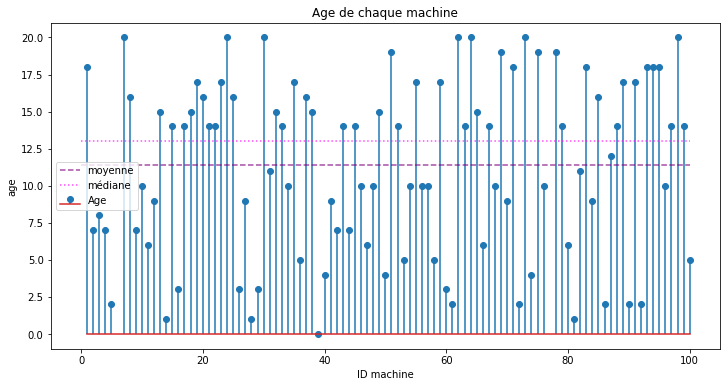

In [7]:
plt.figure(figsize=(12,6))
machines_age = data.groupby('machineID')['age'].mean()
plt.stem(machines_age.index, machines_age, label='Age');
plt.hlines(machines_age.mean(), xmin=0, xmax=100, linestyle='dashed', color='purple', alpha=0.7, label='moyenne')
plt.hlines(machines_age.median(), xmin=0, xmax=100, linestyle = 'dotted', color='magenta', alpha=0.7, label='médiane')
plt.xlabel('ID machine')
plt.ylabel('age')
plt.title('Age de chaque machine');
plt.legend();

Les mesures ont été réalisées sur quelle période de temps ?

In [8]:
print('Première mesure : {}'.format(data['datetime'].min()))
print('Durée totale des mesures : {}'.format((data['datetime'].max() - data['datetime'].min())))

Première mesure : 2015-01-05 00:00:00
Durée totale des mesures : 360 days 00:00:00


Y-a-t-il des dates manquantes dans les mesures ?

In [9]:
# this returns the elements missing, we are hoping to find none
pd.date_range(start = data['datetime'].min(), end = data['datetime'].max(), freq='d').difference(data['datetime'])

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

Y-a-t-il des duplicats ?

In [10]:
data.duplicated().any()

False

Y-a-t-il des valeurs nulles / na ?

In [11]:
data.isna().any().any()

False

Affichons quelques graphes sur les données de mesures ```voltsd_24h```, ```rotatesd_24h```, ```pressuresd_24h```, et ```vibrationsd_24h``` sur 4 machines tirées aléatoirement pour voir à quoi cela ressemble

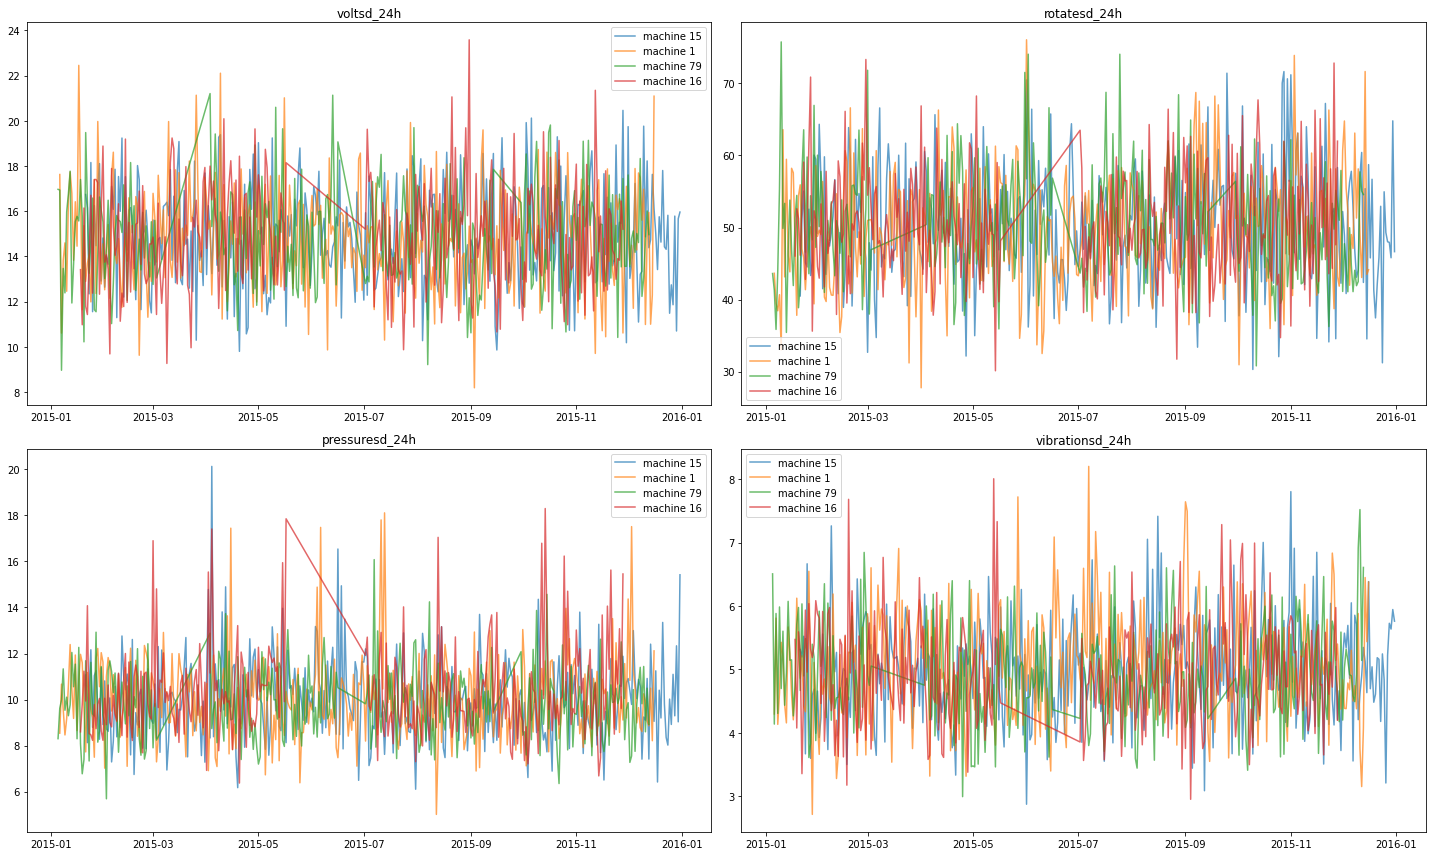

In [12]:
# we prepare our plot
fig = plt.figure(figsize=(20, 12));
k = 1

machineID = np.random.choice(data['machineID'].unique(), 4)
columns_graph = ['voltsd_24h', 'rotatesd_24h', 'pressuresd_24h', 'vibrationsd_24h']

# for each column
for col in columns_graph:
    # we add a subplot
    ax = fig.add_subplot(2, 2, k)
    # we plot the categories in each subplot
    for id in machineID:
        ax.plot(data.loc[data['machineID'] == id, 'datetime'],
                data.loc[data['machineID'] == id, col],
                label = 'machine ' + str(id), alpha=0.7);
        ax.set_title(col);
    #ax.autoscale(axis='x',tight=True);
    ax.legend();
    k+=1
fig.tight_layout()

Il semble y avoir des données lissées sur plusieurs jours, nous allons voir si cela a un impacte sur nos prédictions. Essayons de voir l'évolution des différentes grandeurs numériques au cours du temps. Nous allons rajouter le nombre de pannes en arrière plan de chaque graphique.

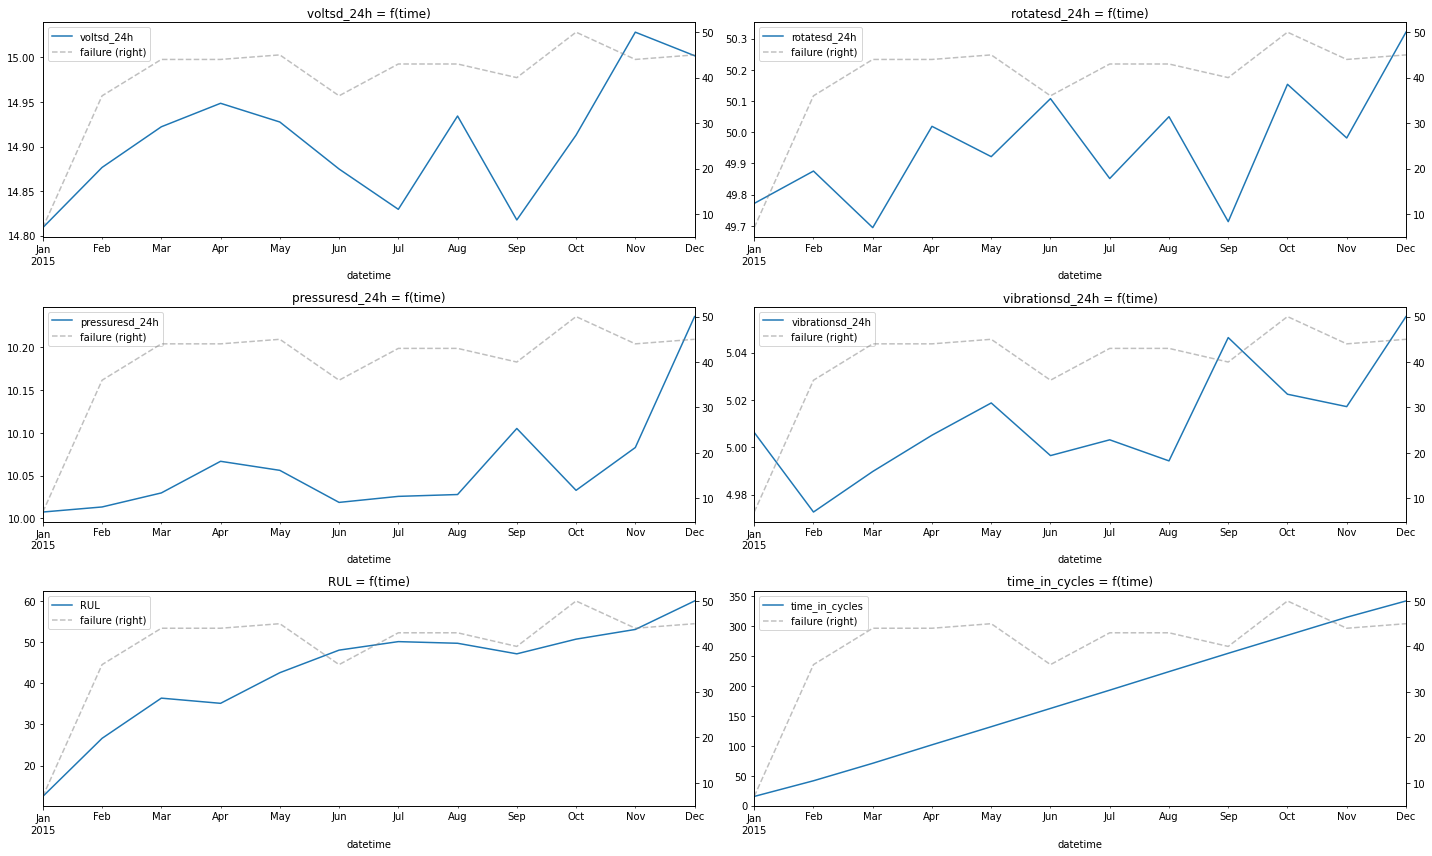

In [13]:
columns_graph = ['voltsd_24h', 'rotatesd_24h', 'pressuresd_24h', 'vibrationsd_24h', 'RUL', 'time_in_cycles']
data_resampled = data.resample(rule='M', on='datetime').mean()[columns_graph].interpolate(method='linear')
data_failure_resampled = data[data['failure'] > 0].resample(rule='M', on='datetime').count()['failure'].interpolate(method='linear')

# we prepare our plot
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 12))

k=0
# we plot the column data in each subplot
for i in range(3):
    for j in range(2):
        data_resampled[columns_graph[k]].plot(ax=axes[i,j], legend=columns_graph[k]);
        data_failure_resampled.plot(secondary_y=True, ax=axes[i,j], legend='failures count', alpha=0.5, linestyle='dashed', color='gray');
        axes[i,j].set_title(columns_graph[k]+' = f(time)')
        k+=1
fig.tight_layout();

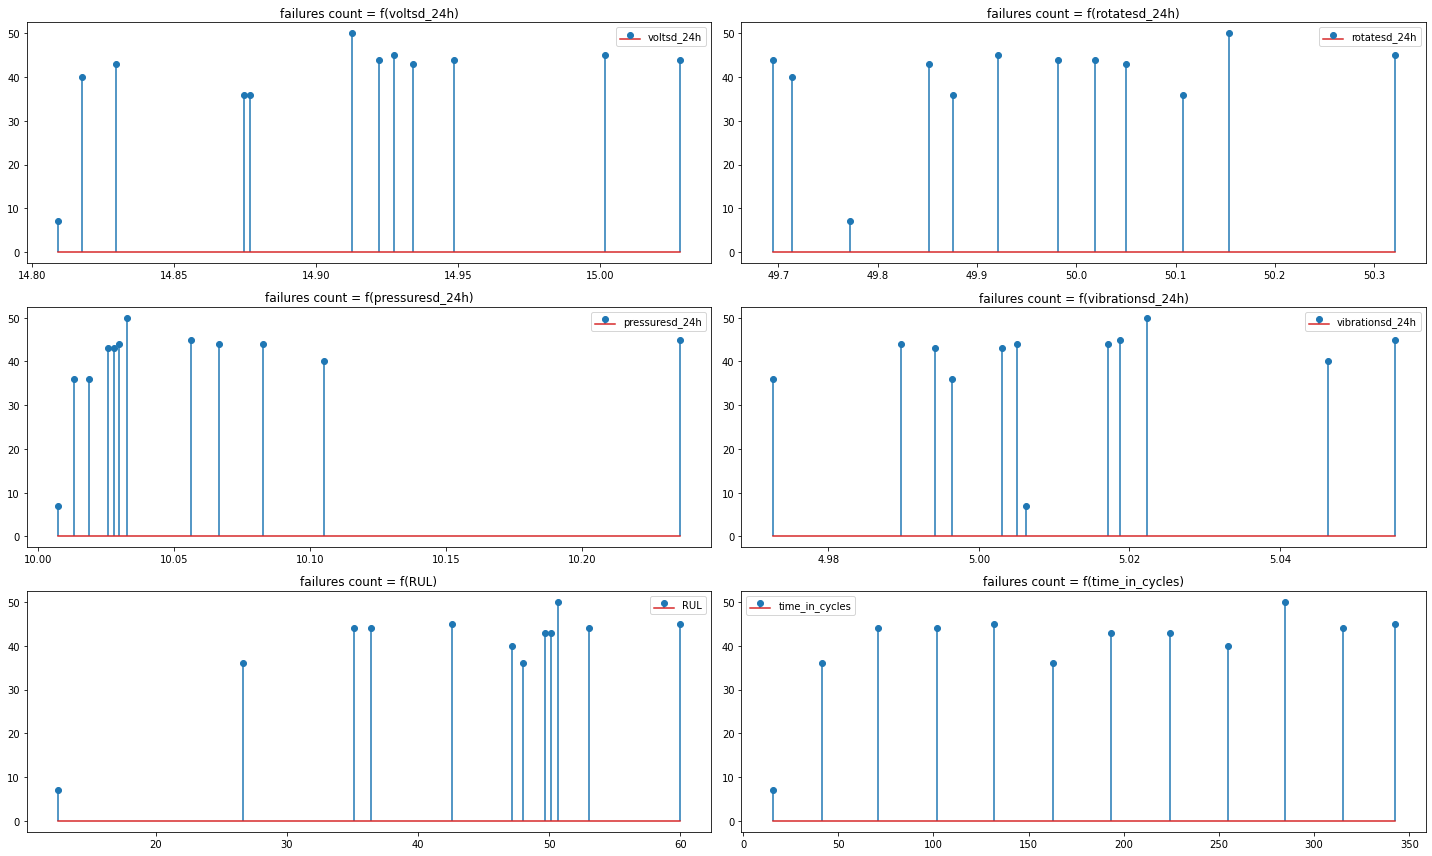

In [25]:
columns_graph = ['voltsd_24h', 'rotatesd_24h', 'pressuresd_24h', 'vibrationsd_24h', 'RUL', 'time_in_cycles']
data_resampled = data.resample(rule='M', on='datetime').mean()[columns_graph].interpolate(method='linear')
data_failure_resampled = data[data['failure'] > 0].resample(rule='M', on='datetime').count()['failure'].interpolate(method='linear')

# we prepare our plot
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 12))

k=0
# we plot the column data in each subplot
for i in range(3):
    for j in range(2):
        axes[i,j].stem(data_resampled[columns_graph[k]], data_failure_resampled,label=columns_graph[k]);
        #data_failure_resampled.plot(secondary_y=True, ax=axes[i,j], legend='failures count', alpha=0.5, linestyle='dashed', color='gray');
        axes[i,j].set_title('failures count = f('+ columns_graph[k] +')')
        axes[i,j].legend()
        k+=1
fig.tight_layout();

On peut aussi tracer un histogramme du nombre de panne par type de panne, pour voir s'il y a un type qui apparaît plus souvent. Nous allons tracer la même chose avec le nombre d'erreurs.

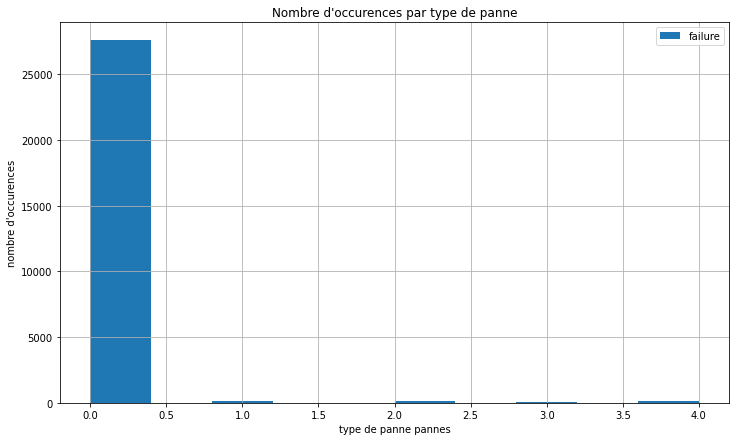

In [15]:
# we prepare our plot
data['failure'].hist(figsize=(12, 7), legend='failure');
plt.xlabel('type de panne pannes')
plt.ylabel('nombre d\'occurences')
plt.title('Nombre d\'occurences par type de panne')
plt.legend();

In [16]:
print('Pourcentage de la classe 0 par rapport aux autres classes : {:.2%}'.format(1 - data.loc[data['failure'] > 0, 'failure'].count()/data['failure'].count()))

Pourcentage de la classe 0 par rapport aux autres classes : 98.30%


On constate déjà une grosse disparité entre les classes et notamment la classe 0 qui correspond au cas où il n'y a pas de pannes (ie fonctionnement normal) puisque la classe 0 représente plus de 98% des effectifs de classe. Il faudrait donc s'orienter vers des algorithmes capable de gérer ces grosses disparités. En complément, on pourra essayer de regrouper tous les échecs dans une même catégorie dans un premier temps afin d'augmenter l'effectif de la classe pour faire classification en deux temps : échec? (True ou False) puis quel type d'échec si failure=True.

On constate cependant qu'il semble y avoir un lien entre le nombre d'erreurs et le nombre de pannes.

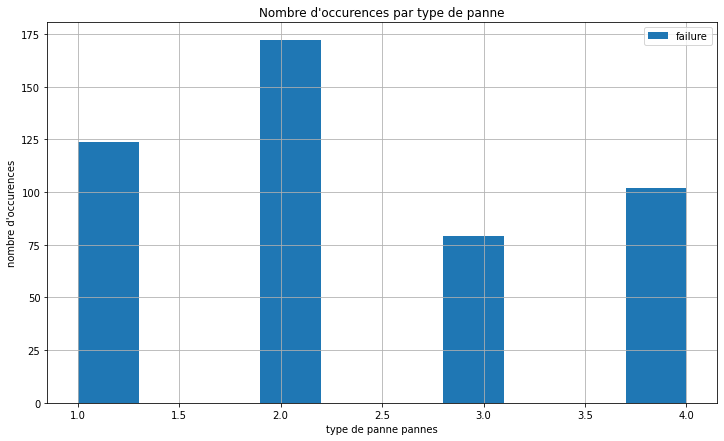

In [17]:
data['failure'][data['failure'] > 0].hist(figsize=(12, 7), legend='failure');
plt.xlabel('type de panne pannes')
plt.ylabel('nombre d\'occurences')
plt.title('Nombre d\'occurences par type de panne');

Affichons un histogramme du nombre d'erreurs simultanées

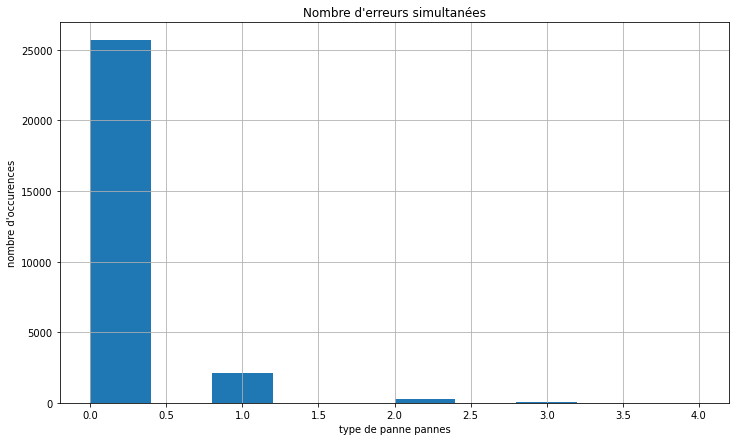

In [18]:
# we prepare our plot
(data['error1']+data['error2']+data['error3']+data['error4']).hist(figsize=(12, 7));
plt.xlabel('type de panne pannes');
plt.ylabel('nombre d\'occurences');
plt.title('Nombre d\'erreurs simultanées');

Le type d'échec une fois la classe 0 (pas d'échec) retirée : les classes échec sont réparties à peu près uniformément à première vue.

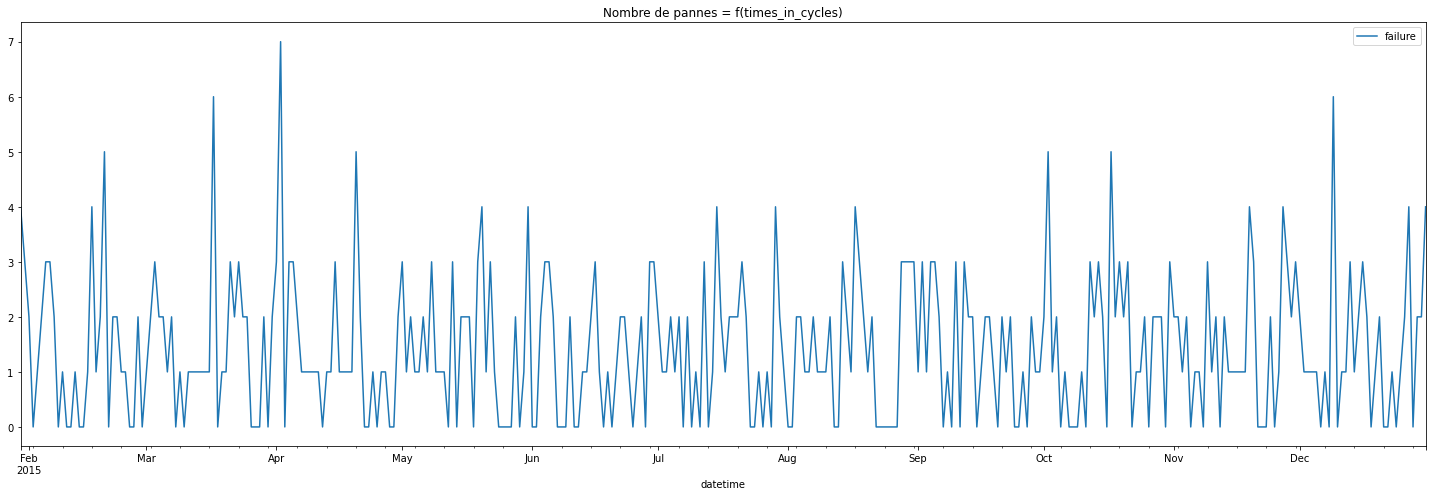

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 7))
data[data['failure'] > 0].resample(rule='D', on='datetime').count()['failure'].interpolate(method='linear').plot(legend='failures', ax=ax);
#ax.set_xticks(np.arange(0, 360, 10));
ax.set_title('Number of failures = f(time)');
ax.legend()
ax.set_title('Nombre de pannes = f(times_in_cycles)');
fig.tight_layout()

Observons comment les différentes covariables intéragissent entre elles et avec la variable à expliquer.

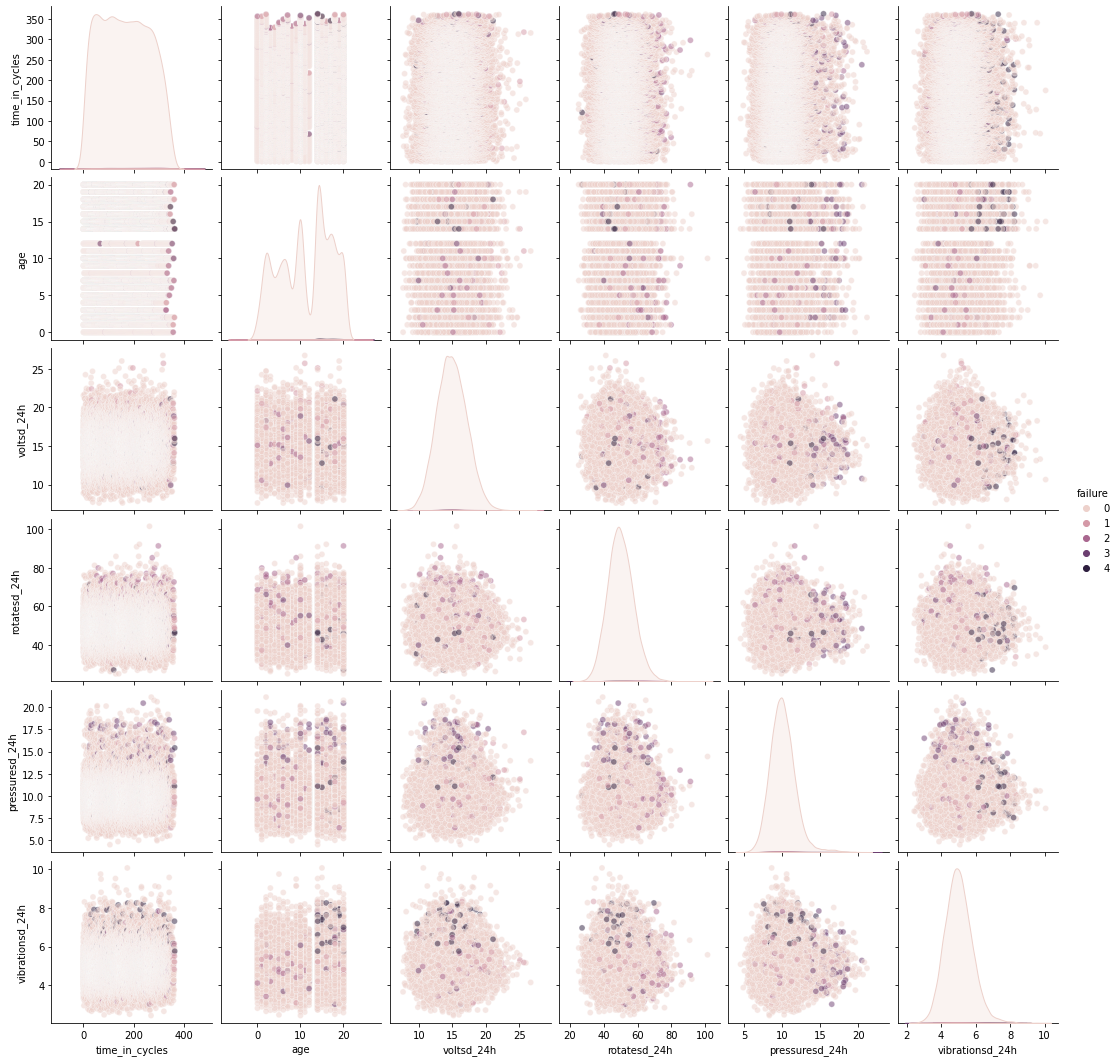

In [20]:
num_columns = ['time_in_cycles', 'age',
               'voltsd_24h', 'rotatesd_24h', 'pressuresd_24h', 'vibrationsd_24h',
               'failure']
sns.pairplot(data[num_columns], hue='failure', plot_kws={'alpha':0.5});

Observons les mêmes graphes sans la classe failure = 0.

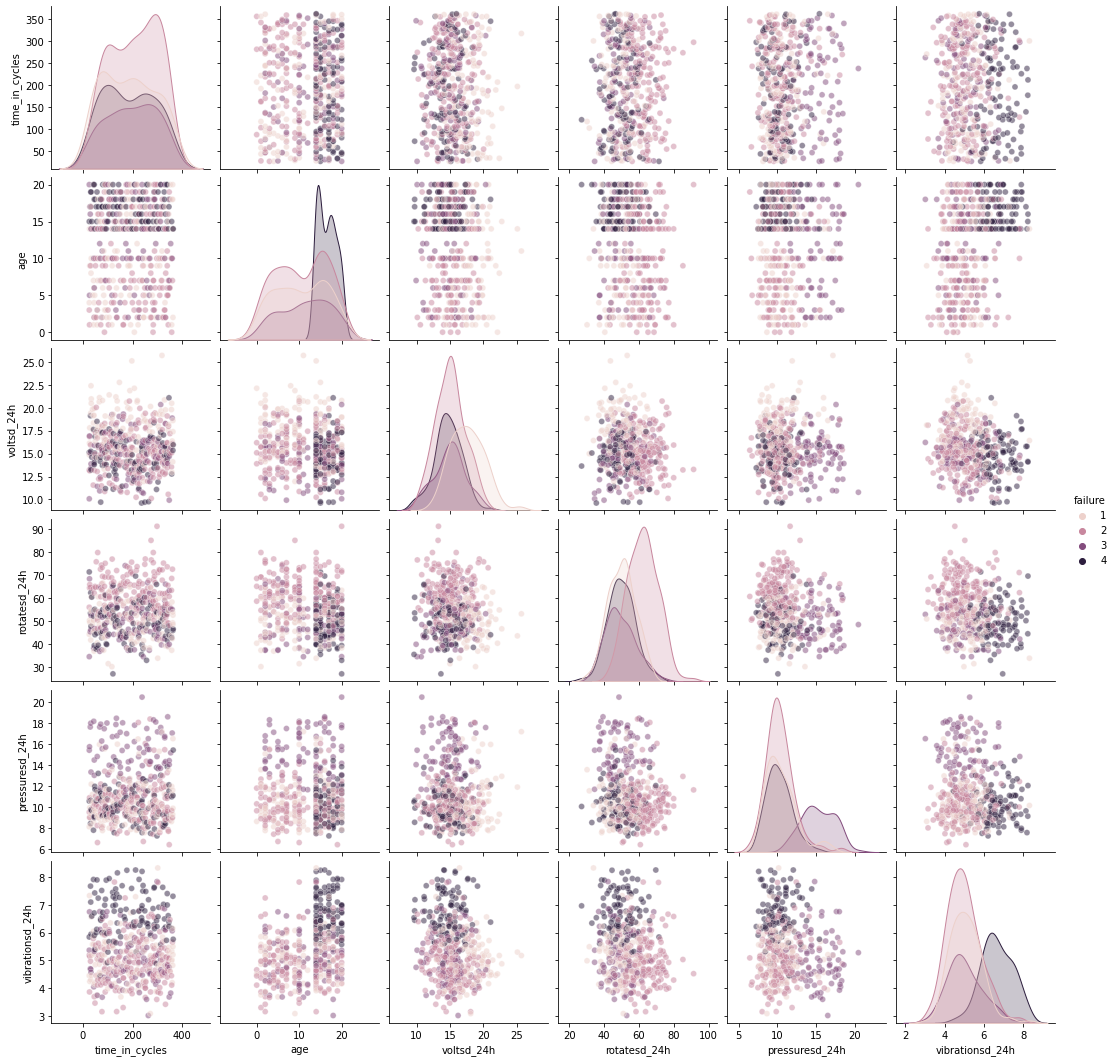

In [21]:
num_columns = ['time_in_cycles', 'age',
               'voltsd_24h', 'rotatesd_24h', 'pressuresd_24h', 'vibrationsd_24h',
               'failure']
sns.pairplot(data.loc[data['failure'] > 0, num_columns], hue='failure', plot_kws={'alpha':0.5});

# Partie 2 : Classification
## 1. Sélection des features

Sklearn possède des outils pour séléctionner les colonnes qui auront le plus d'influence pour une classification. Essayons d'isoler des colonnes numériques et des colonnes en one hot.

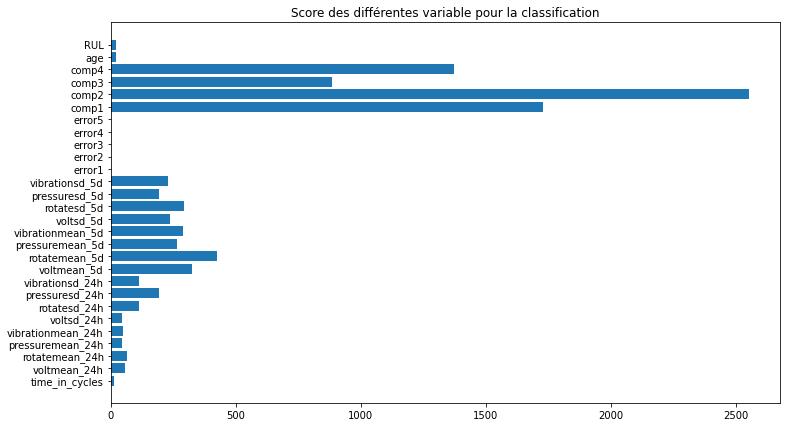

In [149]:
from sklearn.feature_selection import SelectKBest

fs = SelectKBest()
tested_cols = ['time_in_cycles', 'voltmean_24h',
       'rotatemean_24h', 'pressuremean_24h', 'vibrationmean_24h', 'voltsd_24h',
       'rotatesd_24h', 'pressuresd_24h', 'vibrationsd_24h', 'voltmean_5d',
       'rotatemean_5d', 'pressuremean_5d', 'vibrationmean_5d', 'voltsd_5d',
       'rotatesd_5d', 'pressuresd_5d', 'vibrationsd_5d', 'error1', 'error2',
       'error3', 'error4', 'error5', 'comp1', 'comp2', 'comp3', 'comp4',
       'age', 'RUL']
fs.fit_transform(data[tested_cols], data['failure'])

plt.figure(figsize=(12, 7))
plt.barh(y=tested_cols, width=fs.scores_);

plt.title('Score des différentes variable pour la classification');


Les colonnes numériques ```voltmean_5d```, ```rotatemean_5d```, ```pressuremean_5d```, ```vibrationmean_5d``` ont l'air particulièrement significatives, elles sont de plus résonables à estimer lors d'un processus industriel en faisant une moyenne glissante sur 5 jours. Nous allons également rajouter les colonnes ```age``` et ```time_in_cycle``` qui semblent importantes pour lagestion d'un park de machines. Les colonnes one hot ```comp1```, ```comp2```, ```comp3```, et ```comp4``` ont l'air particulièrement significatives. Nous allons les utiliser pour notre classification.

## 2. Préparation des données

Commençons par préparer nos données pour appliquer des algorithmes de classification. Nous allons isoler les colonnes qui nous intéressent et nous allons les normaliser.

In [150]:
# on commence par isoler les colonnes qui nous intéressent
num_cols = ['voltmean_5d', 'rotatemean_5d', 'pressuremean_5d', 'vibrationmean_5d', 'time_in_cycles', 'age']
oh_cols = ['comp1', 'comp2', 'comp3', 'comp4'] # ['error1', 'error2', 'error4', 'error5']

data_norm = data[num_cols + oh_cols + ['failure']].copy()

# code pour ajouter des colonnes model en one hot
#data_norm = data[num_cols + oh_cols + ['failure']].join(pd.get_dummies(data['model'])).copy()
# on met la liste à jour au cas où
#oh_cols += ['model1', 'model2', 'model3' ,'model4']

data_norm.head()

voltmean_5d  rotatemean_5d  pressuremean_5d  vibrationmean_5d  \
0   170.962819     456.080741       108.934097         40.763086   
1   178.731965     454.273917        98.917027         40.336058   
2   169.170151     447.200266        99.881870         40.146042   
3   171.942095     436.106835        99.768365         40.056742   
4   169.435054     455.654105        99.332215         40.264774   

   time_in_cycles  age  comp1  comp2  comp3  comp4  failure  
0               1   18      0      0      0      0        0  
1               1    7      0      0      0      0        0  
2               1   10      0      0      0      0        0  
3               1    7      0      0      0      0        0  
4               1   17      0      0      0      0        0

Ensuite nous allons découper notre jeu de données pour avoir un jeu d'entrainement et un jeu de test.

In [151]:
X_train, X_test, y_train, y_test = train_test_split(data_norm[num_cols + oh_cols], data_norm['failure'], test_size=0.2)

Nous pouvons normaliser nos données d'entrainement et de test.

In [152]:
from sklearn.preprocessing import StandardScaler

# on fit le scaler
scaler = StandardScaler()
scaler.fit(X_train[num_cols])
X_train[num_cols] = scaler.transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

X_train.head()

voltmean_5d  rotatemean_5d  pressuremean_5d  vibrationmean_5d  \
18754     2.702577       0.082560        -0.468473         -0.020543   
27843    -0.290529      -0.748086        -0.544947         -0.184662   
26290    -0.298626       0.415278         2.579188         -0.430151   
6752      0.166300       0.289621        -0.204163         -0.429905   
4134     -0.734755       1.015876         0.010830         -0.474902   

       time_in_cycles       age  comp1  comp2  comp3  comp4  
18754        0.538935  1.489770      0      0      0      0  
27843        1.909291  0.474161      0      0      0      0  
26290        1.540349  1.320502      0      0      0      0  
6752        -0.905208  0.643429      0      0      0      0  
4134        -1.210903  0.812697      0      0      0      0

Au vu de la disparité des classes, nous allons également créer un jeu de données avec un effectif réduit pour la classe 0. On fixe effective de la classe 0 = effectif de toutes les autres classes x 2. Ce choix est arbitraire, il serait de plus intéressant de le faire varier. Une limitation de cette approche est que nous limitons grandement l'échantillon d'entrainement.

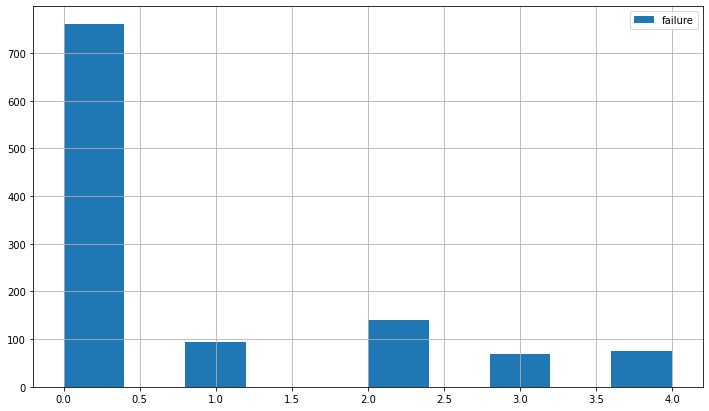

In [158]:
nb_failures = X_train.join(y_train)[X_train.join(y_train)['failure'] > 0].shape[0]
data_train_reduced = X_train.join(y_train)[X_train.join(y_train)['failure'] > 0].append(X_train.join(y_train)[X_train.join(y_train)['failure'] == 0].sample(n=nb_failures*2))
X_train_reduced, y_train_reduced = data_train_reduced.iloc[:, :-1], data_train_reduced.iloc[:, -1]
data_train_reduced['failure'].hist(figsize=(12, 7), legend='failure');

Une autre possibilité est d'augmenter l'effectif des classes minoritaires en générant des données synthétiques. La librairie SMOTE permet de faire cela facilement. Nous allons générer un nouveau jeu de données d'entrainement avec cette librairie et l'enregistrer au format CSV pour pouvoir le réutiliser sans avoir à executer le code utilisant SMOTE plus tard. Nous allons limiter la taille totale du jeu de données généré de sorte à ce que la taille du nouveau jeu de données généré n'excède pas la taille du jeu de données initial

In [154]:
# A n'executer qu'une seule fois
# from imblearn.over_sampling import SMOTE

# data_sample = X_train.join(y_train).sample(X_train.shape[0]//4, random_state=42)
# X_train_sample, y_train_sample = data_sample.iloc[:, :-1], data_sample.iloc[:, -1]
# sm = SMOTE(random_state=42)
# X_train_smote, y_train_smote = sm.fit_resample(X_train_sample, y_train_sample)
# X_train_smote.join(y_train_smote).to_csv('train_data_smote.csv', index=False)

# X_train_smote.shape

(27660, 10)

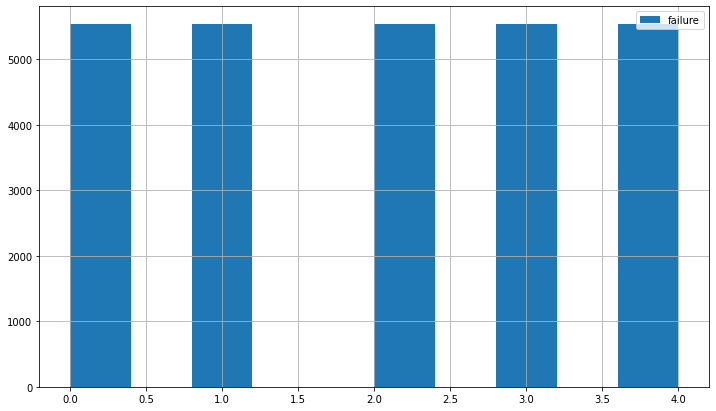

In [155]:
data_augmented = pd.read_csv('train_data_smote.csv')
X_train_augmented, y_train_augmented = data_augmented.iloc[:, :-1], data_augmented.iloc[:, -1]
data_augmented['failure'].hist(figsize=(12, 7), legend='failure');

# 2. Classification

Le choix de la metrique d'évaluation est important pour la suite afin de pouvoir comparer les différents algorithmes. Dans notre cas, nous voulons surtout éviter les faux négatifs. Dans ce genre de situation on définie le score $F_\beta$ comme suit :
$$
F_\beta = (1+\beta^2) \frac{precision \cdot recall}{(\beta^2 \cdot precision + recall)}
$$

Une valeur usuelle pour privilégier le taux de recalls est $\beta$ = 2. Dans la suite nous allons donc utiliser cette métrique, ainsi que la métrique pour $\beta$ = 1 (F-score équilibré) à titre de comparaison.

Pour plus d'informations sur le F-score : [Documentation officielle de Sklearn](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics).

Nous allons commencer par définir une fonction permettant tester plusieurs valeurs d'un paramètre sur un estimateur afin de déterminer la valeur qui maximise le score.

In [159]:
from sklearn.metrics import fbeta_score

# on définie une fonction qui permet de chercher la meilleure valeur d'un paramètre pour un classifieur
def plot_scores_param(X_train, X_test, y_train, y_test, estimator, param_name, param_range, other_params={}):
    f2_score = []
    score = []
    for p in param_range:
        classifier = estimator(**{param_name:p}, **other_params)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)

        f2_score.append((fbeta_score(y_test, y_pred, average='macro', beta=2)))
        score.append(classifier.score(X_test, y_test))

    best_param = np.argmax(f2_score)

    plt.figure(figsize=(10, 6));
    plt.plot(param_range, score, label='mse', color='grey', linestyle='dashed');
    plt.plot(param_range, f2_score, label='f2 score');
    plt.scatter(param_range[best_param], f2_score[best_param], label='f2 min', marker='x', s=100, color='red')
    plt.legend();
    plt.title('f2 and mse = f(k)');
    plt.show();

    print('Meilleur f2 score={:.2f} optenu pour {}={:.2f}'.format(f2_score[best_param], param_name, param_range[best_param]))

    classifier = estimator(**{param_name:param_range[best_param]})
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    sns.heatmap(pd.crosstab(y_test, y_pred), annot=True, fmt='d');
    plt.title('Resultats avec {}={:.2f}'.format(param_name, param_range[best_param]));
    plt.show();

    return param_name, param_range[best_param], f2_score[best_param]

# on crée une variable dans laquelle nous allons stocker nos résultats au fur et à mesure.
classifier_scores = pd.DataFrame(columns=['Classifieur', 'f2 score', 'f2 score sur réduit', 'f2 score sur augmenté'])

### Clustering : $k$-means

Un premier algorithme vu en classe est le k-means. Par curiosité essayons de tracer la courbe du coude vue en classe pour tenter d'identifier la meilleure valeur de k. Ici nous avons déjà un objectif sur le nombre de classes, mais nous pouvons quand même essayer pour voir à quoi cela ressemble sur notre jeu de données.

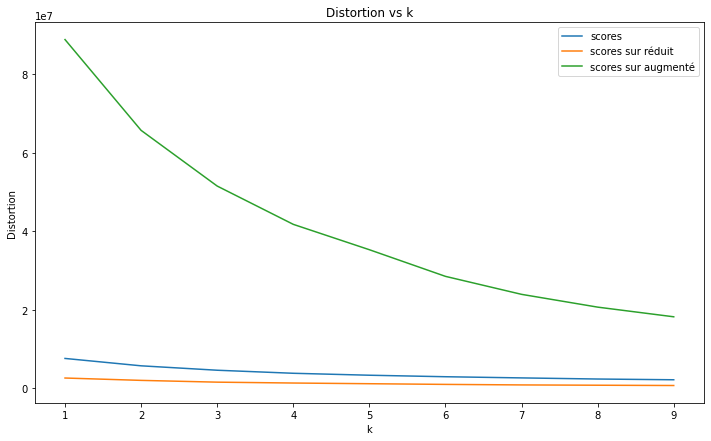

In [160]:
elbow_scores = []
elbow_scores_reduced = []
elbow_scores_augmented = []

k_range = list(range(1, 10))
# on prend une valeur de k entre 1 et 10
for k in k_range:
    # On fait touner le k-means pour chaque valeur de k
    kmeans_algo = cluster.KMeans(n_clusters=k)
    kmeans_algo.fit_transform(X_train)
    # on fait une liste des scores
    elbow_scores.append(kmeans_algo.inertia_)

    # on en fait de même pour le jeu réduit
    kmeans_algo.fit_transform(X_train_reduced)
    elbow_scores_reduced.append(kmeans_algo.inertia_)

    # on en fait de même pour le jeu réduit
    kmeans_algo.fit_transform(X_train_augmented)
    elbow_scores_augmented.append(kmeans_algo.inertia_)


# On affiche nos score en fonction de k
plt.figure(figsize=(12, 7));
plt.plot(k_range, elbow_scores, label='scores')
plt.plot(k_range, elbow_scores_reduced, label='scores sur réduit')
plt.plot(k_range, elbow_scores_augmented, label='scores sur augmenté')
plt.xlabel("k");
plt.ylabel("Distortion");
plt.legend();
plt.title('Distortion vs k');

On ne constate pas de coude évident, ce qui laisse présager qu'il sera difficile de classer nos données en plusieurs classes. Il est intéressant de noter qu'après plusieurs tests avec différentes colonnes du jeu de données, ce graphe donne une bonne première idée de la performance relative des algorithmes de classification. Plus le coude est marqué, plus il semble que les algorithmes de classification vont obtenir un meilleur score.

Essayons de faire touner un k-means avec 5 clusters pour voir si l'algorithme arrive a découper le jeu de données entre les 5 classes : 1 classe pour pas d'échec, et 4 classes pour les 4 types d'échec

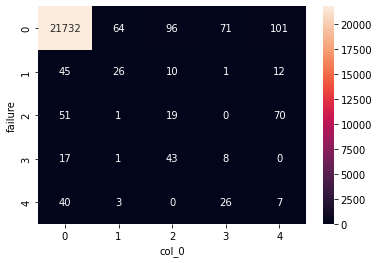

In [161]:
# on applique l'algorithme k-means
#on essaie d'identifier 5 groupes
kmeans_algo = cluster.KMeans(n_clusters=5)
kmeans_results = kmeans_algo.fit_transform(X_train)

# on peut afficher une heatmap pour émuler une matrice de confusion
sns.heatmap(pd.crosstab(y_train, kmeans_algo.labels_), annot=True, fmt='d');

Comme prévu l'algorithme ne présente pas de très bon résultats. Tournons-nous vers des algorithmes plus adaptés à notre problème.

### Classifieurs Ensemblistes
### 1. Random Forest Classifier

Un premier classifieur que nous pouvons essayer sur notre jeu de données est le Random 

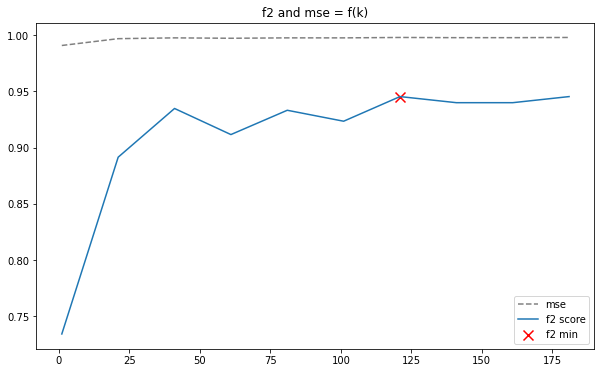

Meilleur f2 score=0.95 optenu pour n_estimators=121.00


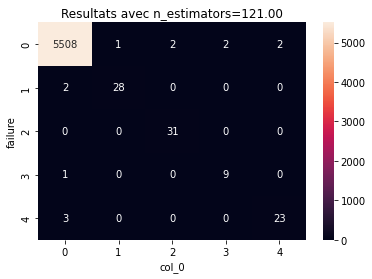

In [162]:
from sklearn.ensemble import RandomForestClassifier

n_range = list(range(1, 200, 20))
_, _, best_f2 = plot_scores_param(X_train, X_test, y_train, y_test, RandomForestClassifier, 'n_estimators', n_range);

Ce classificateur n'obtient pas un bon score, et le parametre n_estimators semble avoir peu d'influence sur le score. Essayons sur le jeu de données réduit.

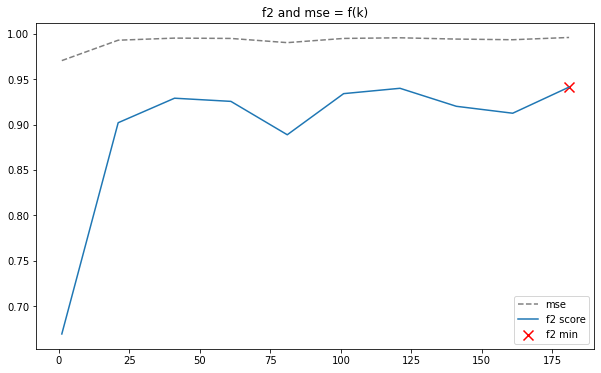

Meilleur f2 score=0.94 optenu pour n_estimators=181.00


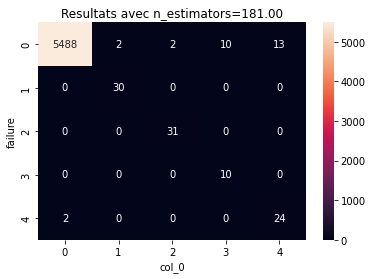

In [163]:
_, _, best_f2_red = plot_scores_param(X_train_reduced, X_test, y_train_reduced, y_test, RandomForestClassifier, 'n_estimators', n_range);

Le classifieur retourne de meilleurs résultats une fois entrainé sur les données d'entrainement avec un effectif de classe 0 réduit.

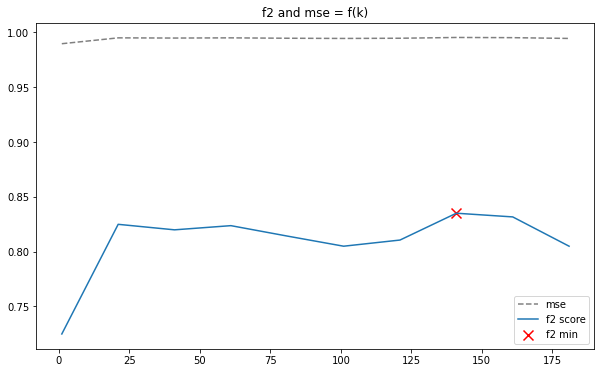

Meilleur f2 score=0.84 optenu pour n_estimators=141.00


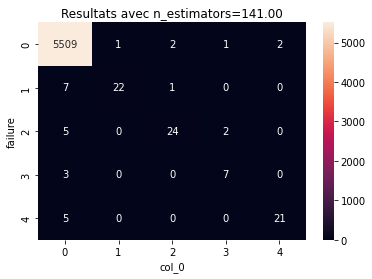

In [164]:
_, _, best_f2_augm = plot_scores_param(X_train_augmented, X_test, y_train_augmented, y_test, RandomForestClassifier, 'n_estimators', n_range);
classifier_scores = classifier_scores.append({'Classifieur': 'RandomForestClassifier', 'f2 score':best_f2, 'f2 score sur réduit': best_f2_red, 'f2 score sur augmenté': best_f2_augm}, ignore_index=True)

Nous obtenons des résultats moins bons avec le jeu de données augmenté.

### Classifieurs Ensemblistes
### 2. Gradient Boosting Classifier

C'est le classifieur qui semble être privilégié d'après la litérature pour ce type d'application. Il présente plusieurs paramètres ajustables. Nous allons essayer d'en ajuster trois. PLut^ot que de faire une echerche par quadrillage (grid search) qui serait longue à calculer nous allons essayer d'ajuster un paramètre après l'autre en gardant à chaque fois la meilleure valeur de chaque paramètre.

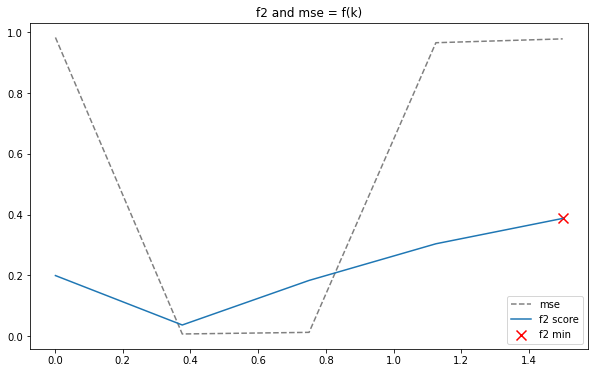

Meilleur f2 score=0.39 optenu pour learning_rate=1.50


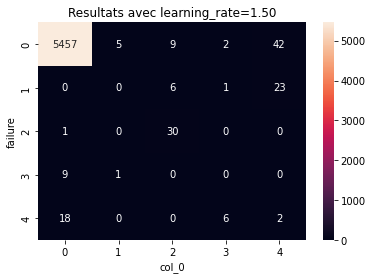

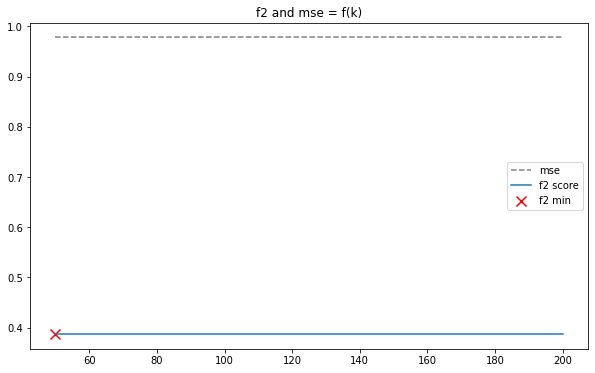

Meilleur f2 score=0.39 optenu pour n_estimators=50.00


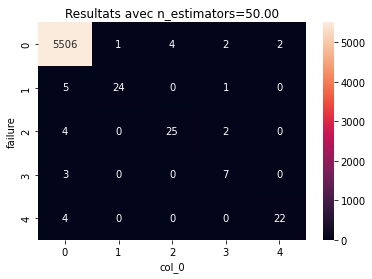

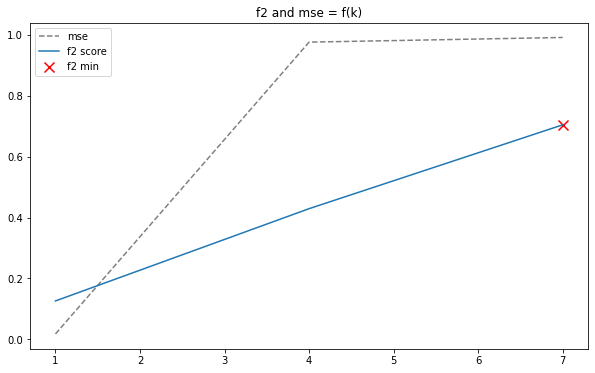

Meilleur f2 score=0.70 optenu pour max_depth=7.00


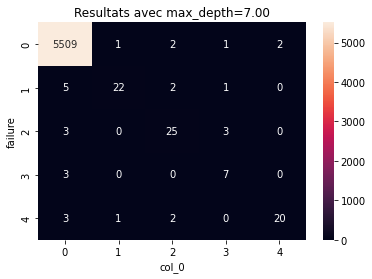

In [165]:
from sklearn.ensemble import GradientBoostingClassifier

l_range = np.linspace(1e-3, 2, num=5)
_, l_value, _ = plot_scores_param(X_train, X_test, y_train, y_test, GradientBoostingClassifier, 'learning_rate', l_range, {'n_estimators':100, 'max_depth':3})

n_range = list(range(50, 201, 50))
_, n_value, _= plot_scores_param(X_train, X_test, y_train, y_test, GradientBoostingClassifier, 'n_estimators', n_range, {'learning_rate':l_value, 'max_depth':3});

m_range = list(range(1, 14, 4))
_, _, best_f2 = plot_scores_param(X_train, X_test, y_train, y_test, GradientBoostingClassifier, 'max_depth', m_range, {'n_estimators':n_value, 'learning_rate':l_value});

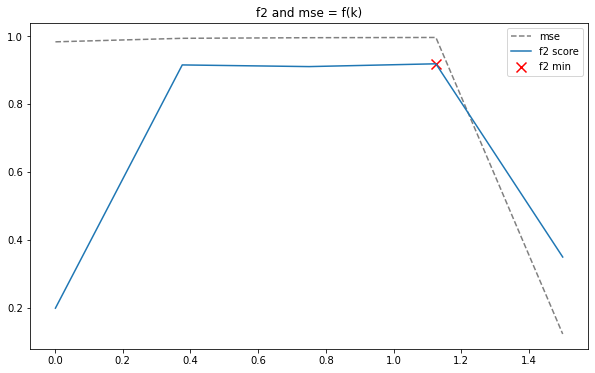

Meilleur f2 score=0.92 optenu pour learning_rate=1.13


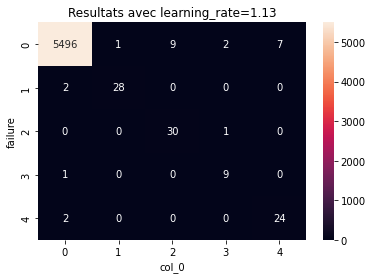

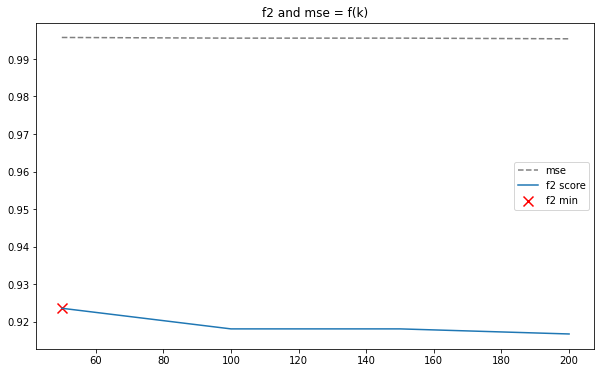

Meilleur f2 score=0.92 optenu pour n_estimators=50.00


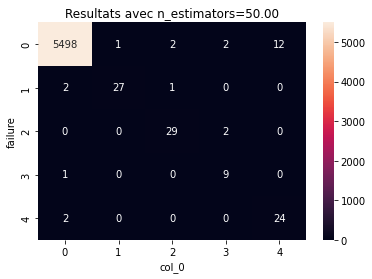

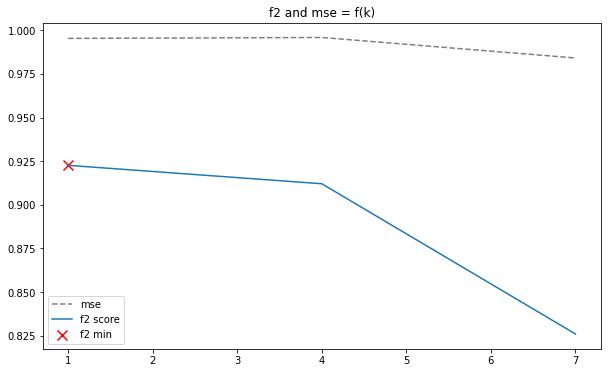

Meilleur f2 score=0.92 optenu pour max_depth=1.00


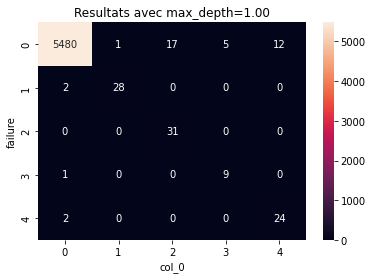

In [166]:
_, l_value, _ = plot_scores_param(X_train_reduced, X_test, y_train_reduced, y_test, GradientBoostingClassifier, 'learning_rate', l_range, {'n_estimators':100, 'max_depth':3})

_, n_value, _ = plot_scores_param(X_train_reduced, X_test, y_train_reduced, y_test, GradientBoostingClassifier, 'n_estimators', n_range, {'learning_rate':l_value, 'max_depth':3});

_,_, best_f2_red = plot_scores_param(X_train_reduced, X_test, y_train_reduced, y_test, GradientBoostingClassifier, 'max_depth', m_range, {'n_estimators':n_value, 'learning_rate':l_value});

Ce classifieur retourne un score variable, il possède de nombreux paramètres à ajuster, ce qui peut s'avérer délicat à optimiser. Le fait de réduire le nombre d'occurences de la classe dominante semble améliorer la matrice de confusion (plus de valeurs diagonales). Il est intéressant de noter que les valeurs optimales des paramètres varient suivant le jeu de données utilisé.

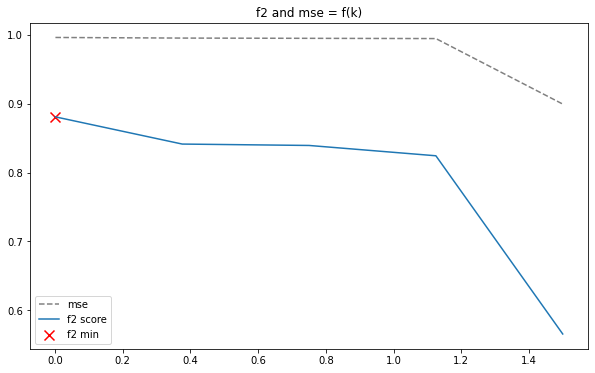

Meilleur f2 score=0.88 optenu pour learning_rate=0.00


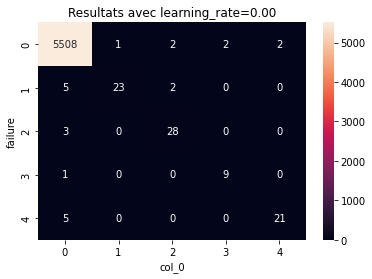

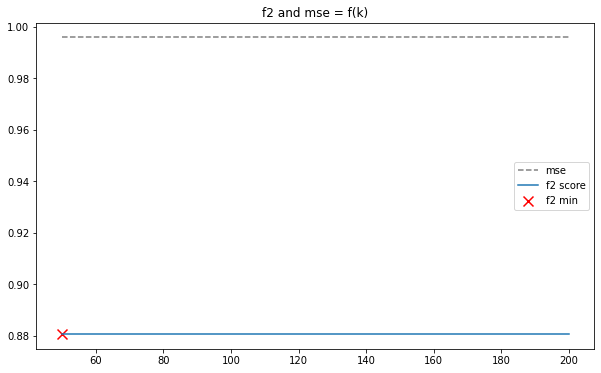

Meilleur f2 score=0.88 optenu pour n_estimators=50.00


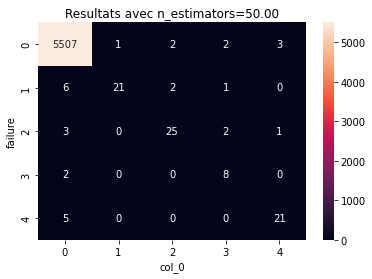

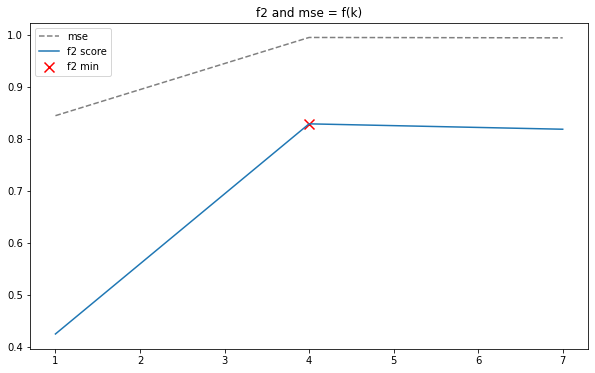

Meilleur f2 score=0.83 optenu pour max_depth=4.00


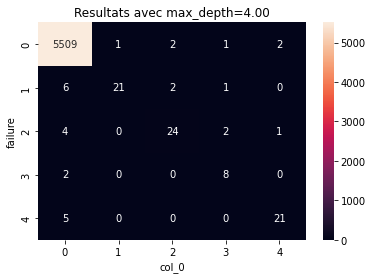

In [167]:
_, l_value, _ = plot_scores_param(X_train_augmented, X_test, y_train_augmented, y_test, GradientBoostingClassifier, 'learning_rate', l_range, {'n_estimators':100, 'max_depth':3})

_, n_value, _ = plot_scores_param(X_train_augmented, X_test, y_train_augmented, y_test, GradientBoostingClassifier, 'n_estimators', n_range, {'learning_rate':l_value, 'max_depth':3});

_,_, best_f2_augm = plot_scores_param(X_train_augmented, X_test, y_train_augmented, y_test, GradientBoostingClassifier, 'max_depth', m_range, {'n_estimators':n_value, 'learning_rate':l_value});

classifier_scores = classifier_scores.append({'Classifieur': 'GradientBoostingClassifier', 'f2 score':best_f2, 'f2 score sur réduit': best_f2_red, 'f2 score sur augmenté': best_f2_augm}, ignore_index=True)

### Classifieurs Ensemblistes à arbre de décision : Decision Tree Classifier

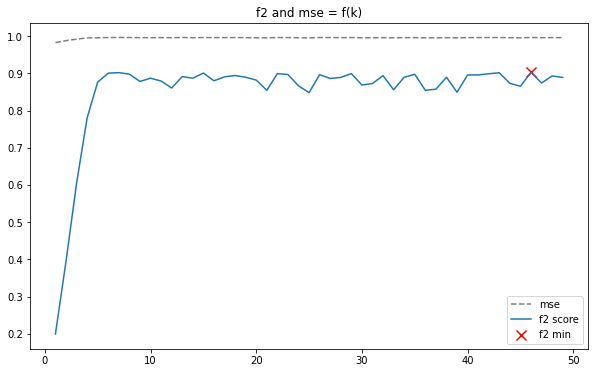

Meilleur f2 score=0.90 optenu pour max_depth=46.00


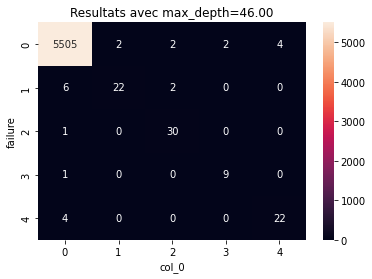

In [168]:
from sklearn.tree import DecisionTreeClassifier

m_range = list(range(1, 50))
_,_,best_f2 = plot_scores_param(X_train, X_test, y_train, y_test, DecisionTreeClassifier, 'max_depth', m_range);

Observons maintenant les résultats sur le jeu de données réduit.

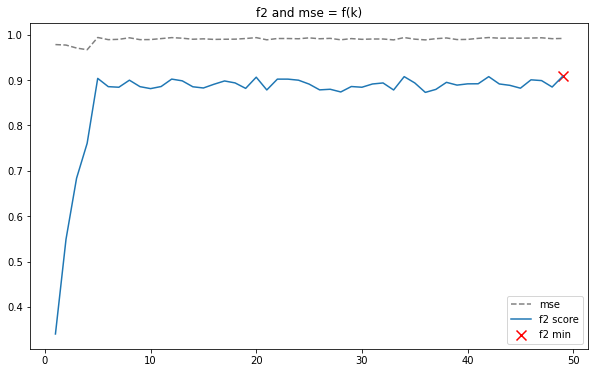

Meilleur f2 score=0.91 optenu pour max_depth=49.00


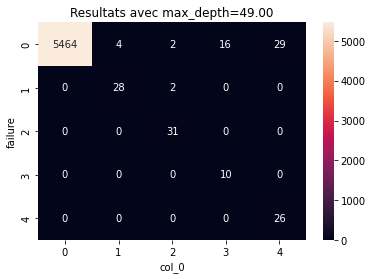

In [169]:
_,_,best_f2_red = plot_scores_param(X_train_reduced, X_test, y_train_reduced, y_test, DecisionTreeClassifier, 'max_depth', m_range);

On constate que ce classifieur peut retourner de bons résultats, surtout avec le jeu de données réduit.

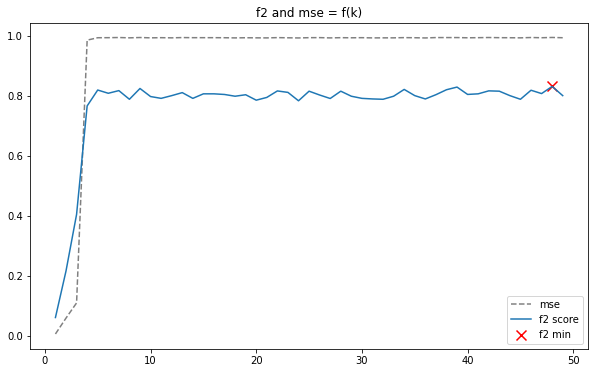

Meilleur f2 score=0.83 optenu pour max_depth=48.00


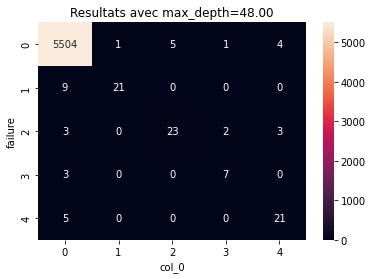

In [170]:
_, _, best_f2_augm = plot_scores_param(X_train_augmented, X_test, y_train_augmented, y_test, DecisionTreeClassifier, 'max_depth', m_range);

classifier_scores = classifier_scores.append({'Classifieur': 'DecisionTreeClassifier', 'f2 score':best_f2, 'f2 score sur réduit': best_f2_red, 'f2 score sur augmenté': best_f2_augm}, ignore_index=True)

### Classifieur naïf : Gaussian Naive Bayes 

Essayons de classifier nos données à l'aide du classifieur Gaussian Naive Bayes. Ce classifeur possède un paramètre 'smoothing' à ajuster. Nous allons essayer plusieurs valeurs de ce paramètre pour voir quelle valeur retourne le meilleur score.

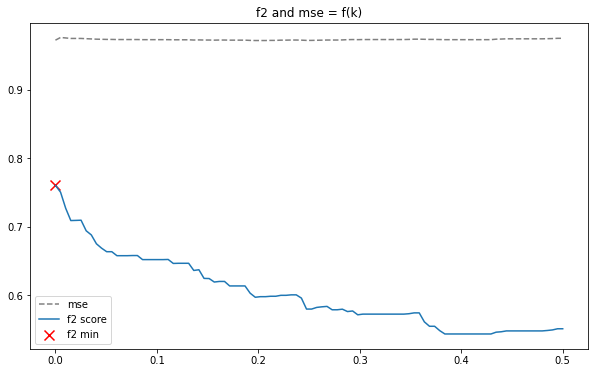

Meilleur f2 score=0.76 optenu pour var_smoothing=0.00


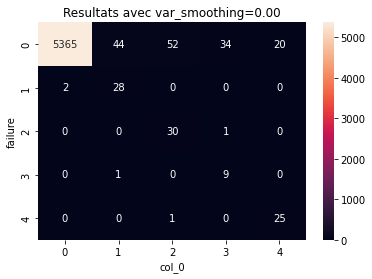

In [171]:
from sklearn.naive_bayes import GaussianNB

s_range = np.linspace(1e-9, 0.5, num=100)
_,_,best_f2 = plot_scores_param(X_train, X_test, y_train, y_test, GaussianNB, 'var_smoothing', s_range);

Ce classifeur présente un score relatvement bon comparé à ceux testés jusqu'ici. Essayons de faire la même chose avec les données réduites.

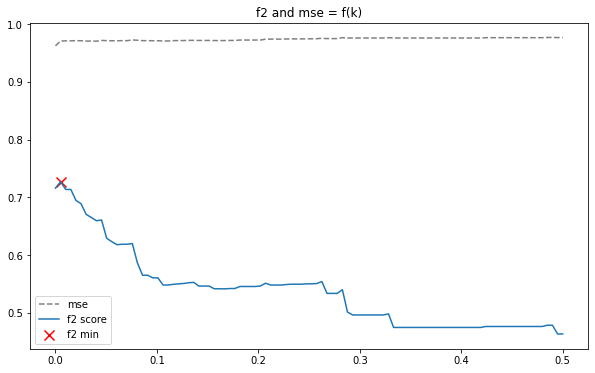

Meilleur f2 score=0.73 optenu pour var_smoothing=0.01


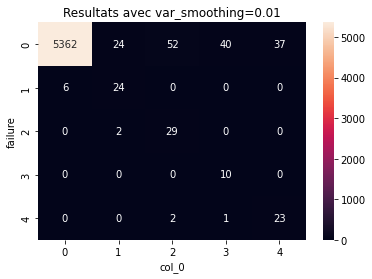

In [172]:
_,_,best_f2_red = plot_scores_param(X_train_reduced, X_test, y_train_reduced, y_test, GaussianNB, 'var_smoothing', s_range);

On constate une amélioration des résultats avec le jeu réduit ce qui est intéressant. C'est l'algorithme qui permet d'atteindre le meilleur score jusqu'à maintenant.

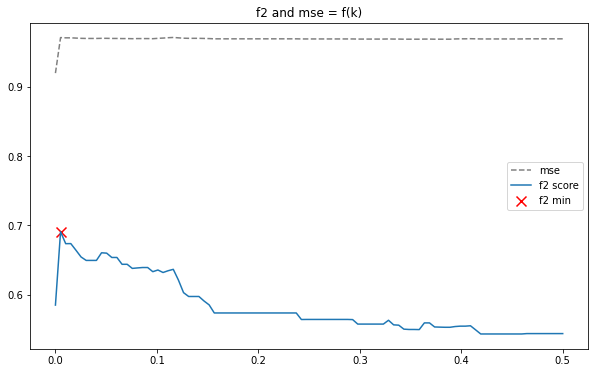

Meilleur f2 score=0.69 optenu pour var_smoothing=0.01


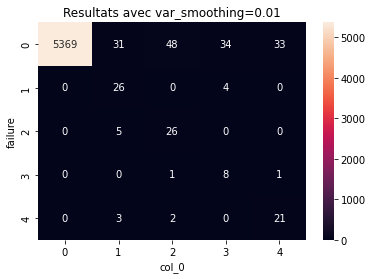

In [173]:
_, _, best_f2_augm = plot_scores_param(X_train_augmented, X_test, y_train_augmented, y_test, GaussianNB, 'var_smoothing', s_range);

classifier_scores = classifier_scores.append({'Classifieur': 'GaussianNB', 'f2 score':best_f2, 'f2 score sur réduit': best_f2_red, 'f2 score sur augmenté': best_f2_augm}, ignore_index=True)

### Classifieurs non linéaires
### 1. K-Voisins

Essayons de classifier nos données à l'aide de la méthode des plus proches voisins

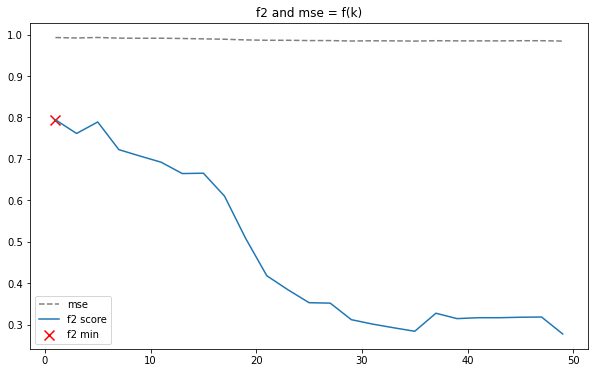

Meilleur f2 score=0.79 optenu pour n_neighbors=1.00


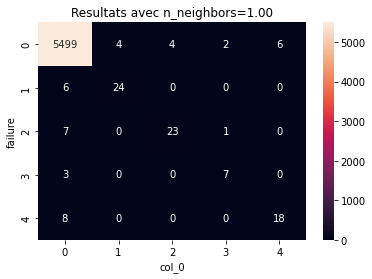

In [174]:
from sklearn.neighbors import KNeighborsClassifier

n_range = range(1, 50, 2)
_,_,best_f2 = plot_scores_param(X_train, X_test, y_train, y_test, KNeighborsClassifier, 'n_neighbors', n_range);

Le meilleur score est obtenu pour n = 1, ce qui est souvent le cas avec cet algorithme. C'est la valeur qui minimise le biais. Voyons comme le classifieur se comporte avec le jeu de données réduit.

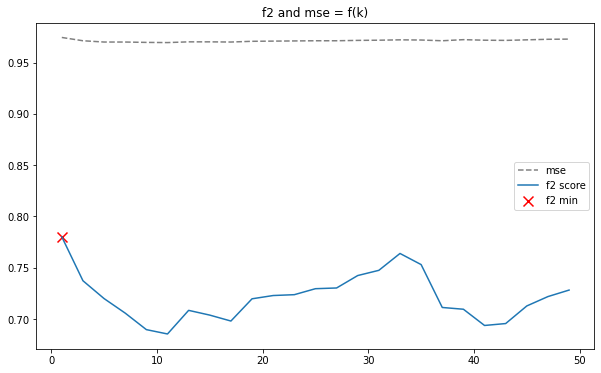

Meilleur f2 score=0.78 optenu pour n_neighbors=1.00


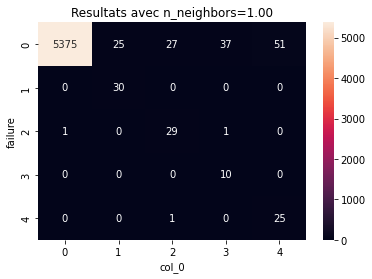

In [175]:
_,_,best_f2_red = plot_scores_param(X_train_reduced, X_test, y_train_reduced, y_test, KNeighborsClassifier, 'n_neighbors', n_range);

Ce classifieur donne un meilleur score une fois entrainé sur le jeu de données réduit mais a tendance à tout classifier dans la même classe.

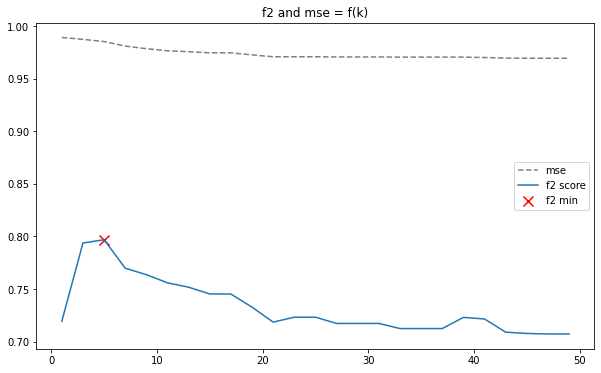

Meilleur f2 score=0.80 optenu pour n_neighbors=5.00


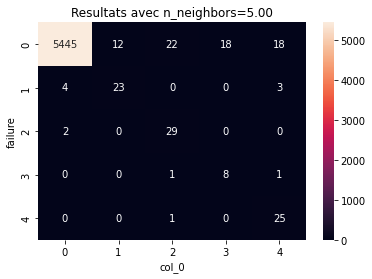

In [176]:
_, _, best_f2_augm = plot_scores_param(X_train_augmented, X_test, y_train_augmented, y_test, KNeighborsClassifier, 'n_neighbors', n_range);

classifier_scores = classifier_scores.append({'Classifieur': 'KNeighborsClassifier', 'f2 score':best_f2, 'f2 score sur réduit': best_f2_red, 'f2 score sur augmenté': best_f2_augm}, ignore_index=True)

### Classifieurs non linéaires
### 2. Linear Discriminant Analysis

Nous n'avons cette fois-ci pas de paramètres à ajuster. Nous allons simplement comparer les résultats entre le modèle ajuster sur le jeu complet vs le jeu réduit.

Fb score avec X_train: 0.72
Fb score avec X_train_reduced: 0.77
Fb score avec X_train_augmented: 0.45


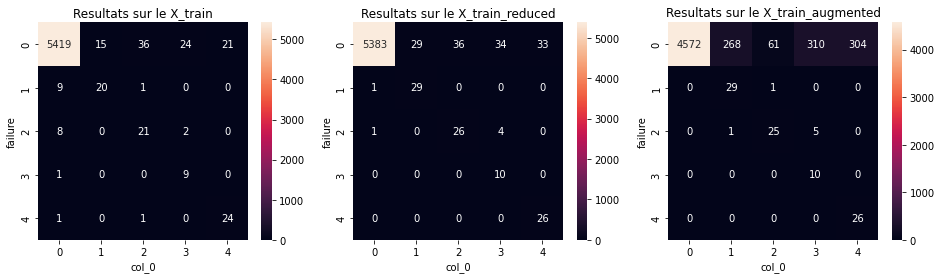

In [177]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_classifier = LinearDiscriminantAnalysis()
lda_classifier.fit(X_train, y_train)
y_pred = lda_classifier.predict(X_test)
best_f2 = fbeta_score(y_test, y_pred, average='macro', beta=2)

fig = plt.figure(figsize=(16,4))
axes = fig.subplots(nrows=1, ncols=3)

sns.heatmap(pd.crosstab(y_test, y_pred), annot=True, fmt='d', ax=axes[0]) ;
axes[0].set_title('Resultats sur le X_train');
print('Fb score avec X_train: {:.2f}'.format(best_f2))

lda_classifier.fit(X_train_reduced, y_train_reduced)
y_pred = lda_classifier.predict(X_test)
best_f2_red = fbeta_score(y_test, y_pred, average='macro', beta=2)

sns.heatmap(pd.crosstab(y_test, y_pred), annot=True, fmt='d', ax=axes[1]);
axes[1].set_title('Resultats sur le X_train_reduced');

print('Fb score avec X_train_reduced: {:.2f}'.format(best_f2_red))

lda_classifier.fit(X_train_augmented, y_train_augmented)
y_pred = lda_classifier.predict(X_test)
best_f2_augm = fbeta_score(y_test, y_pred, average='macro', beta=2)

sns.heatmap(pd.crosstab(y_test, y_pred), annot=True, fmt='d', ax=axes[2]);
axes[2].set_title('Resultats sur le X_train_augmented');

print('Fb score avec X_train_augmented: {:.2f}'.format(best_f2_augm))

classifier_scores = classifier_scores.append({'Classifieur': 'LinearDiscriminantAnalysis', 'f2 score':best_f2, 'f2 score sur réduit': best_f2_red, 'f2 score sur augmenté': best_f2_augm}, ignore_index=True)

Ce classifieur retourne un résultat plutôt bon comparé aux autres algorithmes. On constate de plus une amélioration des résultats avec le jeu de données réduit. Ce classifieur ne necessaite de plus pas d'ajuster des paramètres ce qui est intéressant.

### Classifieurs non linéaires
### 3. Support Vector Machine

Nous pouvons ajuster le paramètre C sur ce modèle.

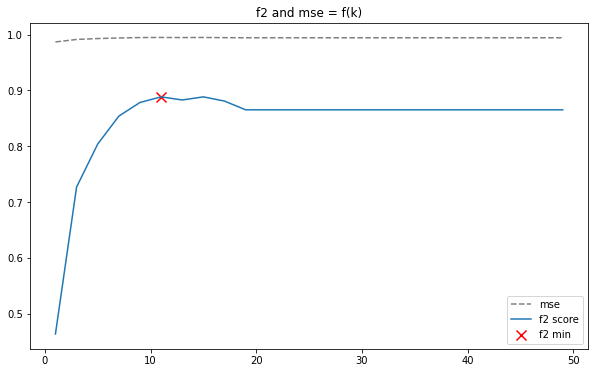

Meilleur f2 score=0.89 optenu pour C=11.00


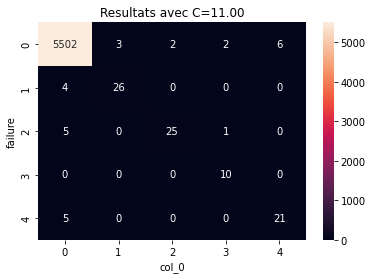

In [178]:
from sklearn.svm import SVC

c_range = list(range(1, 51, 2))
_,_,best_f2 = plot_scores_param(X_train, X_test, y_train, y_test, SVC, 'C', c_range);

Observons les résultats sur le jeu réduit.

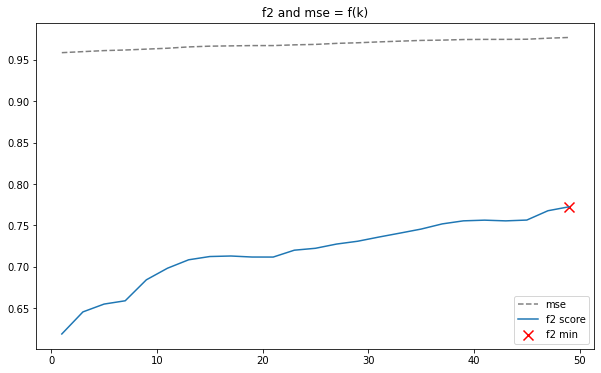

Meilleur f2 score=0.77 optenu pour C=49.00


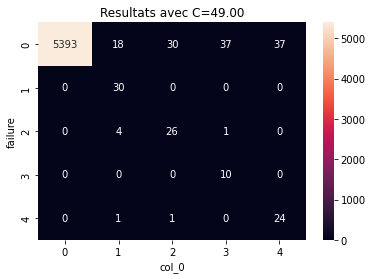

In [179]:
_,_,best_f2_red = plot_scores_param(X_train_reduced, X_test, y_train_reduced, y_test, SVC, 'C', c_range);

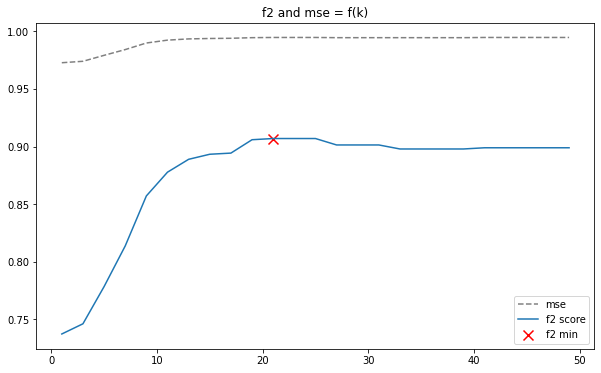

Meilleur f2 score=0.91 optenu pour C=21.00


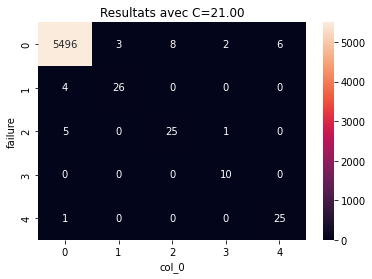

In [180]:
_,_,best_f2_augm = plot_scores_param(X_train_augmented, X_test, y_train_augmented, y_test, SVC, 'C', c_range);
classifier_scores = classifier_scores.append({'Classifieur': 'SVC', 'f2 score':best_f2, 'f2 score sur réduit': best_f2_red, 'f2 score sur augmenté': best_f2_augm}, ignore_index=True)

### Classifieurs linéaires
### 1. SGDClassifier

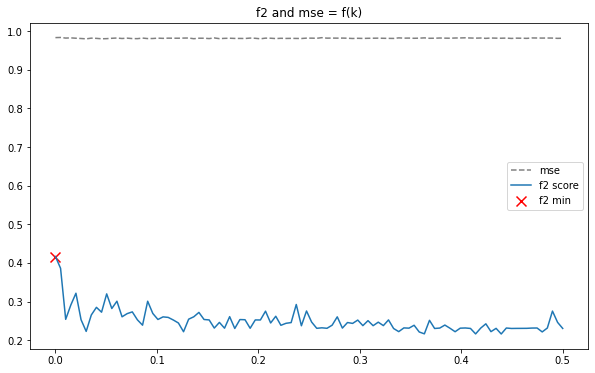

Meilleur f2 score=0.42 optenu pour alpha=0.00


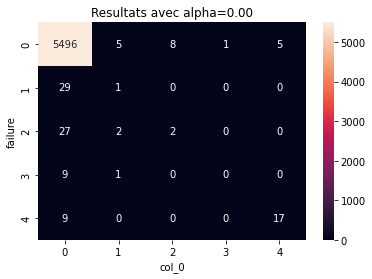

In [181]:
from sklearn.linear_model import SGDClassifier

a_range = np.linspace(1e-5, 0.5, num=100)
_,_,f2_score = plot_scores_param(X_train, X_test, y_train, y_test, SGDClassifier, 'alpha', a_range);

Ce classifieur semble tout attribuer à la classe majoritaire. Voyons sont comportement sur le jeu de données réduit.

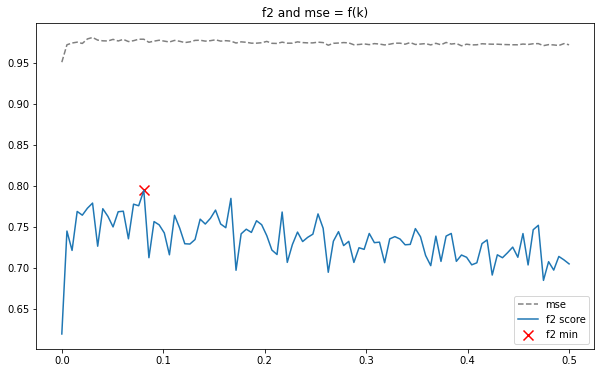

Meilleur f2 score=0.79 optenu pour alpha=0.08


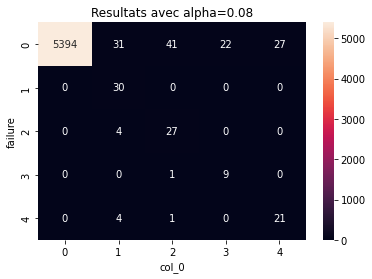

In [182]:
_,_,best_f2_red = plot_scores_param(X_train_reduced, X_test, y_train_reduced, y_test, SGDClassifier, 'alpha', a_range);

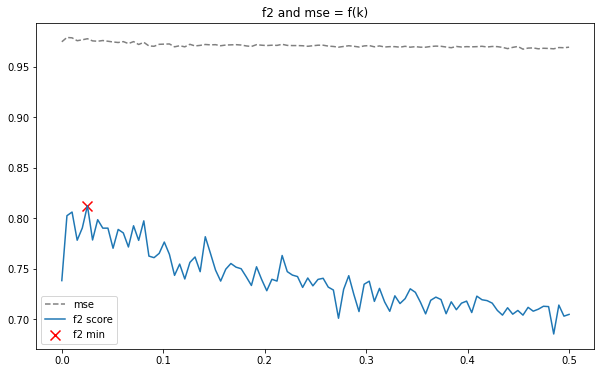

Meilleur f2 score=0.81 optenu pour alpha=0.03


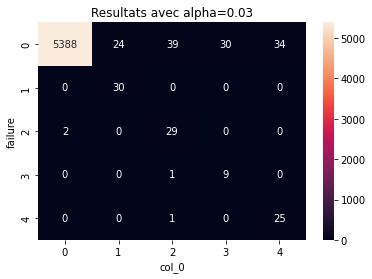

In [183]:
_,_,best_f2_augm = plot_scores_param(X_train_augmented, X_test, y_train_augmented, y_test, SGDClassifier, 'alpha', a_range);
classifier_scores = classifier_scores.append({'Classifieur': 'SGDClassifier', 'f2 score':best_f2, 'f2 score sur réduit': best_f2_red, 'f2 score sur augmenté': best_f2_augm}, ignore_index=True)

On obtient de meilleurs résultats mais le classifieur semble toujours attribuer presque tous les points à la classe majoritaire.

### Classifieurs linéaires
### 2. Logistic Regression

Ce classifieur permet d'ajouter un paramètre de poids, nous allons donc tester plusieurs valeurs poids sur la classe majoritaire 0.

/home/pierre/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pierre/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pierre/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pierre/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pierre/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pierre/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: Con

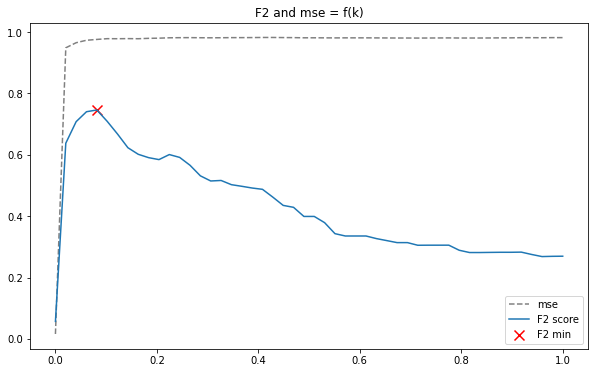

Meilleur Fb score : 0.75 optenu pour w = 0.08


/home/pierre/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


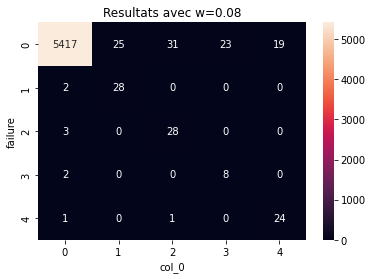

In [184]:
from sklearn.linear_model import LogisticRegression

f2_score = []
score = []
w_range = np.linspace(1e-5, 1, num=50)
for w in w_range:
    lr_classifier = LogisticRegression(class_weight={0: w}, solver='saga')
    lr_classifier.fit(X_train, y_train)
    y_pred = lr_classifier.predict(X_test)

    f2_score.append((fbeta_score(y_test, y_pred, average='macro', beta=2)))
    score.append(lr_classifier.score(X_test, y_test))

best_w = np.argmax(f2_score)
best_f2 = f2_score[best_w]

plt.figure(figsize=(10, 6));
plt.plot(w_range, score, label='mse', color='grey', linestyle='dashed');
plt.plot(w_range, f2_score, label='F2 score');
plt.scatter(w_range[best_w], f2_score[best_w], label='F2 min', marker='x', s=100, color='red')
plt.legend();
plt.title('F2 and mse = f(k)');
plt.show();

print('Meilleur Fb score : {:.2f} optenu pour w = {:.2f}'.format(f2_score[best_w], w_range[best_w]))

lr_classifier =  LogisticRegression(class_weight={0: w_range[best_w]})
lr_classifier.fit(X_train, y_train)
y_pred = lr_classifier.predict(X_test)

sns.heatmap(pd.crosstab(y_test, y_pred), annot=True, fmt='d');
plt.title('Resultats avec w={:.2f}'.format(w_range[best_w]));

On constate que le meilleur score f2 ne correspond pas forcément à la meileur classification. En ajustant les paramètres à la main, on obtient de bons résultats pour un poids en 0 autour de 0.1 

/home/pierre/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pierre/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pierre/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pierre/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pierre/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pierre/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: Con

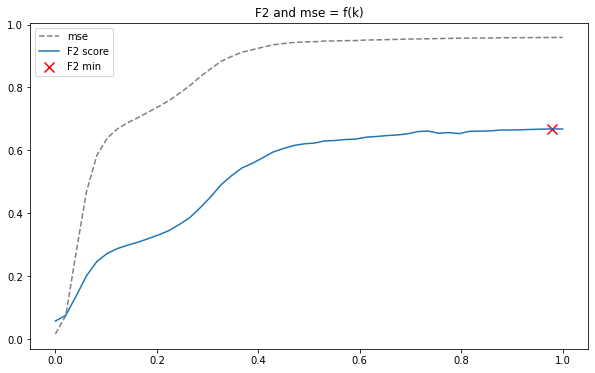

Meilleur Fb score : 0.67 optenu pour w = 0.98


/home/pierre/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


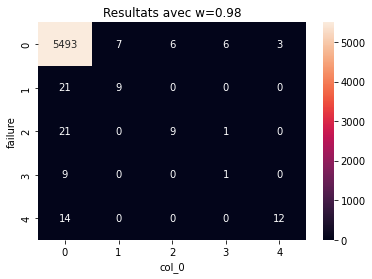

In [185]:
f2_score = []
score = []
w_range = np.linspace(1e-5, 1, num=50)
for w in w_range:
    lr_classifier = LogisticRegression(class_weight={0: w}, solver='saga')
    lr_classifier.fit(X_train_reduced, y_train_reduced)
    y_pred = lr_classifier.predict(X_test)

    f2_score.append((fbeta_score(y_test, y_pred, average='macro', beta=2)))
    score.append(lr_classifier.score(X_test, y_test))

best_w = np.argmax(f2_score)
best_f2_red = f2_score[best_w]

plt.figure(figsize=(10, 6));
plt.plot(w_range, score, label='mse', color='grey', linestyle='dashed');
plt.plot(w_range, f2_score, label='F2 score');
plt.scatter(w_range[best_w], f2_score[best_w], label='F2 min', marker='x', s=100, color='red')
plt.legend();
plt.title('F2 and mse = f(k)');
plt.show();

print('Meilleur Fb score : {:.2f} optenu pour w = {:.2f}'.format(f2_score[best_w], w_range[best_w]))

lr_classifier =  LogisticRegression(class_weight={0: w_range[best_w]})
lr_classifier.fit(X_train, y_train)
y_pred = lr_classifier.predict(X_test)

sns.heatmap(pd.crosstab(y_test, y_pred), annot=True, fmt='d');
plt.title('Resultats avec w={:.2f}'.format(w_range[best_w]));

/home/pierre/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pierre/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pierre/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pierre/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pierre/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pierre/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: Con

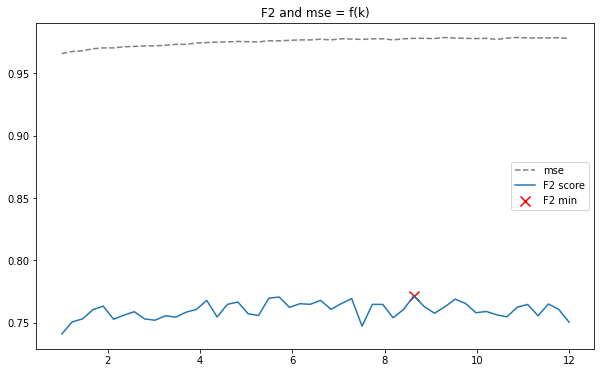

Meilleur Fb score : 0.77 optenu pour w = 8.63


/home/pierre/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


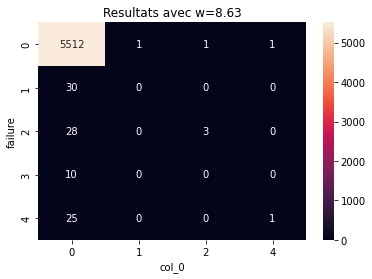

In [186]:
f2_score = []
score = []
w_range = np.linspace(1, 12, num=50)
for w in w_range:
    lr_classifier = LogisticRegression(class_weight={0: w}, solver='saga', max_iter=500)
    lr_classifier.fit(X_train_augmented, y_train_augmented)
    y_pred = lr_classifier.predict(X_test)

    f2_score.append((fbeta_score(y_test, y_pred, average='macro', beta=2)))
    score.append(lr_classifier.score(X_test, y_test))

best_w = np.argmax(f2_score)
best_f2_augm = f2_score[best_w]

plt.figure(figsize=(10, 6));
plt.plot(w_range, score, label='mse', color='grey', linestyle='dashed');
plt.plot(w_range, f2_score, label='F2 score');
plt.scatter(w_range[best_w], f2_score[best_w], label='F2 min', marker='x', s=100, color='red')
plt.legend();
plt.title('F2 and mse = f(k)');
plt.show();

print('Meilleur Fb score : {:.2f} optenu pour w = {:.2f}'.format(f2_score[best_w], w_range[best_w]))

lr_classifier =  LogisticRegression(class_weight={0: w_range[best_w]})
lr_classifier.fit(X_train, y_train)
y_pred = lr_classifier.predict(X_test)

sns.heatmap(pd.crosstab(y_test, y_pred), annot=True, fmt='d');
plt.title('Resultats avec w={:.2f}'.format(w_range[best_w]));

classifier_scores = classifier_scores.append({'Classifieur': 'LogisticRegression', 'f2 score':best_f2, 'f2 score sur réduit': best_f2_red, 'f2 score sur augmenté': best_f2_augm}, ignore_index=True)

On constate que le poids attribué à la classe majoritaire est proche de 1 sur le jeu réduit et proche de 10 sur le jeu augmenté. On constate de plus que bien que le score puisse être plus élevé sur le jeu de données réduite et augmenté les matrices de confusion sont moins bonnes. Ce classifieur est le seul jusqu'à maintenant qui permette d'ajuster le poids de la classe majoritaire.

In [187]:
classifier_scores

Classifieur  f2 score  f2 score sur réduit  \
0      RandomForestClassifier  0.945311             0.941237   
1  GradientBoostingClassifier  0.704411             0.922603   
2      DecisionTreeClassifier  0.902685             0.908531   
3                  GaussianNB  0.760544             0.726901   
4        KNeighborsClassifier  0.794467             0.780085   
5  LinearDiscriminantAnalysis  0.721929             0.771990   
6                         SVC  0.888565             0.772593   
7               SGDClassifier  0.888565             0.794194   
8          LogisticRegression  0.746167             0.667954   

   f2 score sur augmenté  
0               0.835048  
1               0.828905  
2               0.831533  
3               0.690734  
4               0.796925  
5               0.446840  
6               0.906973  
7               0.812484  
8               0.771468